In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [2]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [3]:
train_imgs = []
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))

train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5

In [4]:
def make_generator_model(shape):
    
    input_layer = Input(shape=shape)
    
    x = Dense(16*16*64*2)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 128))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model(input_layer, x)

In [5]:
generator = make_generator_model((100,))
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 32768)             3309568   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 32)        36864 

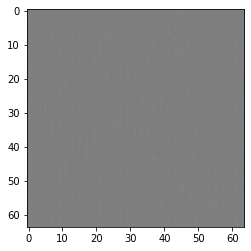

In [6]:
generator = make_generator_model((100,))

noise = np.random.normal(0, 1, 100)

generated_image = generator.predict(np.array([noise]))[0]
plt.imshow(unnormalize_img(generated_image), )

In [7]:
def make_discriminator_model():
    input_layer = Input((64, 64, 3))
    x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Dense(1)(x)
    
    return Model(input_layer, x)

In [8]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator.predict(np.array([generated_image]))
print (decision)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0   

In [9]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output, flip):
    
    if flip:
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0)
        real_labels = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1)
    else:
        real_labels = tf.random.uniform(real_output.shape, minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.1)

        
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [17]:
@tf.function
def train_step(images, flip):
    noise = tf.random.truncated_normal([32, 100])
    
    gen_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss, disc_real_loss, disc_fake_loss = discriminator_loss(real_output, fake_output, flip)
        
        gen_losses.append(K.mean(gen_loss))
        disc_losses.append(K.mean(disc_loss))
        disc_real_losses.append(K.mean(disc_real_loss))
        disc_fake_losses.append(K.mean(disc_fake_loss))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_losses, disc_losses, disc_real_losses, disc_fake_losses)

In [13]:
def train(train_imgs, epochs):
    gen_loss_all = []
    disc_loss_all = []
    disc_loss_real_all = []
    disc_loss_fake_all = []
    
    num_imgs = len(train_imgs)
    batch_counter = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        disc_loss_real_epoch = [1, 0]
        disc_loss_fake_epoch = [1, 0]
        
        np.random.shuffle(train_imgs)
        
        for idx, i in enumerate(range(0, num_imgs - 32, 32)):
            gen_loss_batch, disc_loss_batch, disc_loss_real_batch, disc_loss_fake_batch = train_step(train_imgs[i:(i+32)], batch_counter % 10 == 0)

            gen_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            disc_loss_real_epoch[0] += 1
            disc_loss_fake_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            disc_loss_real_epoch[1] += np.mean(disc_loss_real_batch)
            disc_loss_fake_epoch[1] += np.mean(disc_loss_fake_batch)
            
            batch_counter += 1
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Disc loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, Disc real loss: {disc_loss_real_epoch[1]/disc_loss_real_epoch[0]}, Disc fake loss: {disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        disc_loss_real_all.append(disc_loss_real_epoch[1]/disc_loss_real_epoch[0])
        disc_loss_fake_all.append(disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0])
    
    return (gen_loss_all, disc_loss_all, disc_loss_real_all, disc_loss_fake_all)
    


In [14]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, d_hist=None, d_real_hist=None, d_fake_hist=None, noise=None, save_files=False):
    
    if noise is None:
        noise = np.random.normal(0, 1, 100)

    if g_hist is None:
        g_hist = []
    
    if d_hist is None:
        d_hist = []
        
    if d_real_hist is None:
        d_real_hist = []
    
    if d_fake_hist is None:
        d_fake_hist = []

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, disc_temp, disc_real_temp, disc_fake_temp = train(train_imgs, checkpoint_interval)
        g_hist += gen_temp
        d_hist += disc_temp
        d_real_hist += disc_real_temp
        d_fake_hist += disc_fake_temp
        generated_image = generator.predict(np.array([noise]))[0]
        plt.imshow(unnormalize_img(generated_image))
        if save_files:
            plt.savefig('./results/prog-imgs/bird-gan-deeper-smaller-z-balanced/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        if save_files:
            generator.save_weights('./results/weights/bird-gan-deeper-smaller-z-balanced/gen_weights_deeper_smaller_z_balanced_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator.save_weights('./results/weights/bird-gan-deeper-smaller-z-balanced/disc_weights_deeper_smaller_z_balanced_' + str((i+1)*checkpoint_interval) + '.h5')
    
    return starting_checkpoint + num_checkpoints

In [16]:
discriminator = make_discriminator_model()
generator = make_generator_model((100,))
generator.load_weights('./results/weights/bird-gan-deeper-smaller-z-balanced/gen_weights_deeper_smaller_z_balanced_1000.h5')
discriminator.load_weights('./results/weights/bird-gan-deeper-smaller-z-balanced/disc_weights_deeper_smaller_z_balanced_1000.h5')
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [18]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
disc_loss_hist = []
disc_loss_real_hist = []
disc_loss_fake_hist = []
noise100 = np.random.normal(0, 1, 100)
next_starting_checkpoint = 10

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 10

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time for epoch 1 is 16.381787538528442 sec
Gen loss: 1.5455101334305636, Disc loss: 0.9892869457642883, Disc real loss: 0.5037693231086421, Disc fake loss: 0.48551762225182077
Time for epoch 2 is 12.932875871658325 sec
Gen loss: 1.5592278041813754, Disc loss: 0.9883949465867949, Disc real loss: 0.5034818478069978, Disc fake loss: 0.48491309974897845
Time for epoch 3 is 13.002775430679321 

Time for epoch 43 is 13.715400218963623 sec
Gen loss: 1.5422595180470122, Disc loss: 0.9921935355760217, Disc real loss: 0.5100368661124531, Disc fake loss: 0.4821566685751525
Time for epoch 44 is 13.613618612289429 sec
Gen loss: 1.5370520266090952, Disc loss: 0.9892269240485297, Disc real loss: 0.5069150124300463, Disc fake loss: 0.48231191234536935
Time for epoch 45 is 13.70437479019165 sec
Gen loss: 1.548630771921256, Disc loss: 0.9813603177303221, Disc real loss: 0.5012487526023938, Disc fake loss: 0.48011156658170023
Time for epoch 46 is 13.626574993133545 sec
Gen loss: 1.5325844652930571, Disc loss: 0.9963855825788607, Disc real loss: 0.5073476632436117, Disc fake loss: 0.4890379216774369
Time for epoch 47 is 13.600650787353516 sec
Gen loss: 1.5525087667351494, Disc loss: 0.9860939758256845, Disc real loss: 0.5023078179456354, Disc fake loss: 0.4837861585261699
Time for epoch 48 is 13.659495830535889 sec
Gen loss: 1.5515072636488008, Disc loss: 0.9905033660774955, Disc real loss:

Time for epoch 90 is 13.643535852432251 sec
Gen loss: 1.542128893741101, Disc loss: 0.9852367625003908, Disc real loss: 0.5027650245806066, Disc fake loss: 0.48247173735442844
Time for epoch 91 is 13.683048725128174 sec
Gen loss: 1.564466939709051, Disc loss: 0.9856331072202543, Disc real loss: 0.5001136467547275, Disc fake loss: 0.48551946078858726
Time for epoch 92 is 13.672459125518799 sec
Gen loss: 1.5555859846151294, Disc loss: 0.9838552053381757, Disc real loss: 0.4997154151198018, Disc fake loss: 0.4841397898145484
Time for epoch 93 is 13.675461530685425 sec
Gen loss: 1.5450529499751766, Disc loss: 0.9851879786023603, Disc real loss: 0.5030396699420805, Disc fake loss: 0.4821483091448704
Time for epoch 94 is 13.665466070175171 sec
Gen loss: 1.5533867977498992, Disc loss: 0.9933468583153515, Disc real loss: 0.5079179120257618, Disc fake loss: 0.48542894733953607
Time for epoch 95 is 13.660489082336426 sec
Gen loss: 1.547903944160234, Disc loss: 0.9795737263309924, Disc real loss:

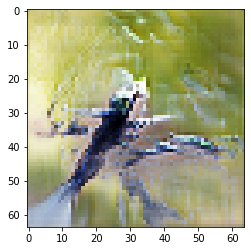

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 11

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.596660852432251 sec
Gen loss: 1.5608528342027328, Disc loss: 0.9898081636687281, Disc real loss: 0.5023407420814845, Disc fake loss: 0.48746742069882754
Time for epoch 2 is 13.760238885879517 sec
Gen loss: 1.5252837346498236, Disc loss: 0.9934543642571302, Disc real loss: 0.5062739041843388, Disc fake loss: 0.4871804615669457
Time for epoch 3 is 13.605622291564941 sec
Gen loss: 1.5377680072939492, Disc loss: 0.9951684515327619, Disc real loss: 0.5054008750734613, Disc fake loss: 0.48976757654006564
Time for epoch 4 is 13.604639768600464 sec
Gen loss: 1.534743971294827, Disc loss: 0.9882923619857003, Disc real loss: 0.5036321299347452, Disc fake loss: 0.4846602321317202
Time for epoch 5 is 13.776181697845459 sec
Gen loss: 1.5636959331145455, Disc loss: 0.9837805678850913, Disc real loss: 0.5017119384393459, Disc fake loss: 0.4820686312225776
Time fo

Time for epoch 48 is 13.339838981628418 sec
Gen loss: 1.5414430381159796, Disc loss: 0.9894276317865222, Disc real loss: 0.505607369227138, Disc fake loss: 0.4838202623170889
Time for epoch 49 is 13.48127007484436 sec
Gen loss: 1.540032323783006, Disc loss: 0.988937801623409, Disc real loss: 0.5067143886069941, Disc fake loss: 0.4822234127741196
Time for epoch 50 is 13.567078590393066 sec
Gen loss: 1.5381803945474186, Disc loss: 0.9920012222396003, Disc real loss: 0.5075615233360591, Disc fake loss: 0.48443969777282986
Time for epoch 51 is 13.43175745010376 sec
Gen loss: 1.5298552471124707, Disc loss: 0.9961836945396775, Disc real loss: 0.5070147145246748, Disc fake loss: 0.48916897791511
Time for epoch 52 is 13.443172931671143 sec
Gen loss: 1.5340212851682007, Disc loss: 0.9915902472446928, Disc real loss: 0.5065488016540766, Disc fake loss: 0.48504144647903236
Time for epoch 53 is 13.433781147003174 sec
Gen loss: 1.5476023197820192, Disc loss: 0.9938790066455437, Disc real loss: 0.50

Time for epoch 95 is 13.476014614105225 sec
Gen loss: 1.557986254614543, Disc loss: 0.9844258322625302, Disc real loss: 0.500486338687783, Disc fake loss: 0.48393949107102907
Time for epoch 96 is 13.409552574157715 sec
Gen loss: 1.5232773473269248, Disc loss: 0.9985211903486795, Disc real loss: 0.5072882880524892, Disc fake loss: 0.49123290302307626
Time for epoch 97 is 13.411394834518433 sec
Gen loss: 1.5243231293954824, Disc loss: 0.9943269106753796, Disc real loss: 0.508629052619624, Disc fake loss: 0.4856978577326953
Time for epoch 98 is 13.450919151306152 sec
Gen loss: 1.5521569216477515, Disc loss: 0.989135659322506, Disc real loss: 0.5039440566689019, Disc fake loss: 0.48519159962491293
Time for epoch 99 is 13.410412311553955 sec
Gen loss: 1.5271276332498567, Disc loss: 0.9938263920587576, Disc real loss: 0.5093624595057996, Disc fake loss: 0.48446393303754853
Time for epoch 100 is 13.40139627456665 sec
Gen loss: 1.532800152695922, Disc loss: 0.9874855376840607, Disc real loss: 

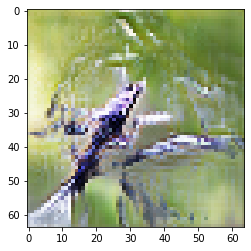

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 12

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.425173997879028 sec
Gen loss: 1.5491560222656746, Disc loss: 0.9874505235896847, Disc real loss: 0.4994743510798064, Disc fake loss: 0.48797617323676423
Time for epoch 2 is 13.408315181732178 sec
Gen loss: 1.5524890009303727, Disc loss: 0.9894032675399367, Disc real loss: 0.5066062053690757, Disc fake loss: 0.48279706209009576
Time for epoch 3 is 13.400512456893921 sec
Gen loss: 1.5448831029054595, Disc loss: 0.9897265442341647, Disc real loss: 0.5080742354638531, Disc fake loss: 0.4816523103048485
Time for epoch 4 is 13.427828550338745 sec
Gen loss: 1.536062090700558, Disc loss: 0.9957341941068489, Disc real loss: 0.5064041438464549, Disc fake loss: 0.48933005219875636
Time for epoch 5 is 13.390928268432617 sec
Gen loss: 1.532635669398114, Disc loss: 0.9906960372033158, Disc real loss: 0.5093607310518663, Disc fake loss: 0.48133530615144954
Time f

Time for epoch 47 is 13.412325859069824 sec
Gen loss: 1.5211115390627687, Disc loss: 1.0039026638679711, Disc real loss: 0.5133154395473035, Disc fake loss: 0.49058722294766083
Time for epoch 48 is 13.402825593948364 sec
Gen loss: 1.5212288358347203, Disc loss: 1.0002087134978959, Disc real loss: 0.5106830237519128, Disc fake loss: 0.48952568643461397
Time for epoch 49 is 13.399868488311768 sec
Gen loss: 1.5192222365841956, Disc loss: 1.000086759648672, Disc real loss: 0.5094833852152837, Disc fake loss: 0.49060337435262313
Time for epoch 50 is 13.403489589691162 sec
Gen loss: 1.5314023688556702, Disc loss: 0.9910905437094732, Disc real loss: 0.50652085757514, Disc fake loss: 0.48456968209607815
Time for epoch 51 is 13.401473760604858 sec
Gen loss: 1.5300711005683836, Disc loss: 0.9923986064063178, Disc real loss: 0.5067851552310675, Disc fake loss: 0.48561345246749194
Time for epoch 52 is 13.351991653442383 sec
Gen loss: 1.5355704754671753, Disc loss: 0.9979455256203649, Disc real los

Time for epoch 94 is 13.45101523399353 sec
Gen loss: 1.5038340120780758, Disc loss: 1.0036824219595126, Disc real loss: 0.5143020383226193, Disc fake loss: 0.4893803848483698
Time for epoch 95 is 13.334283113479614 sec
Gen loss: 1.5345858057663047, Disc loss: 0.9828962229777803, Disc real loss: 0.5006486620844864, Disc fake loss: 0.48224755943952213
Time for epoch 96 is 13.332152128219604 sec
Gen loss: 1.5205352839415636, Disc loss: 1.0002146261494334, Disc real loss: 0.5118384300289438, Disc fake loss: 0.4883761963224023
Time for epoch 97 is 13.411806106567383 sec
Gen loss: 1.527129745095726, Disc loss: 0.9964040816637881, Disc real loss: 0.5077210145429544, Disc fake loss: 0.488683067282364
Time for epoch 98 is 13.488323211669922 sec
Gen loss: 1.541473391902479, Disc loss: 1.0058579044290352, Disc real loss: 0.5121190176423649, Disc fake loss: 0.4937388852521333
Time for epoch 99 is 13.335604906082153 sec
Gen loss: 1.5122333587346684, Disc loss: 1.0003018434131694, Disc real loss: 0.

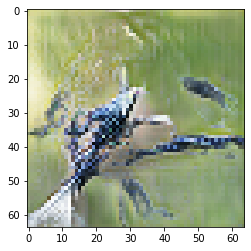

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 13

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.357091903686523 sec
Gen loss: 1.5380646953091712, Disc loss: 1.0017885591602584, Disc real loss: 0.5115481755597805, Disc fake loss: 0.49024038351971283
Time for epoch 2 is 13.474477291107178 sec
Gen loss: 1.5173036202505674, Disc loss: 1.001287274244355, Disc real loss: 0.5086338846341059, Disc fake loss: 0.492653391871672
Time for epoch 3 is 13.309210062026978 sec
Gen loss: 1.5269241962975604, Disc loss: 1.001748487070647, Disc real loss: 0.5127860069436433, Disc fake loss: 0.4889624801270038
Time for epoch 4 is 13.426282405853271 sec
Gen loss: 1.5239056167886833, Disc loss: 0.999546221116694, Disc real loss: 0.5119858136991176, Disc fake loss: 0.4875604083867577
Time for epoch 5 is 13.343812704086304 sec
Gen loss: 1.5301275460054558, Disc loss: 0.9888140714265466, Disc real loss: 0.5048944438860669, Disc fake loss: 0.48391962867119126
Time for e

Time for epoch 48 is 13.428605318069458 sec
Gen loss: 1.5296107320604608, Disc loss: 0.9975113103060218, Disc real loss: 0.50766991591712, Disc fake loss: 0.4898413932581904
Time for epoch 49 is 13.419738054275513 sec
Gen loss: 1.5182798894117195, Disc loss: 0.9963087811056515, Disc real loss: 0.5089511296290369, Disc fake loss: 0.48735765365727224
Time for epoch 50 is 13.433946371078491 sec
Gen loss: 1.531604107479416, Disc loss: 0.9938257574065914, Disc real loss: 0.5112969347939582, Disc fake loss: 0.4825288260855326
Time for epoch 51 is 13.308393716812134 sec
Gen loss: 1.5367830497462576, Disc loss: 0.9977907026363259, Disc real loss: 0.507980410080292, Disc fake loss: 0.48981029053690633
Time for epoch 52 is 13.410038471221924 sec
Gen loss: 1.5381251153584095, Disc loss: 0.993155827528739, Disc real loss: 0.5092401922072175, Disc fake loss: 0.48391563839059537
Time for epoch 53 is 13.489625453948975 sec
Gen loss: 1.5396611496684998, Disc loss: 0.9977776976781809, Disc real loss: 0

Time for epoch 95 is 13.380002975463867 sec
Gen loss: 1.5151276517366652, Disc loss: 0.9969803048020133, Disc real loss: 0.5073448002823, Disc fake loss: 0.4896355062965455
Time for epoch 96 is 13.407137632369995 sec
Gen loss: 1.5233000681652287, Disc loss: 0.9978934358452071, Disc real loss: 0.5098134225946132, Disc fake loss: 0.4880800131698288
Time for epoch 97 is 13.512069940567017 sec
Gen loss: 1.5209429868191562, Disc loss: 1.000563962672784, Disc real loss: 0.5127314743472309, Disc fake loss: 0.48783248937549956
Time for epoch 98 is 13.344924211502075 sec
Gen loss: 1.5363543004524418, Disc loss: 0.9958947690198738, Disc real loss: 0.5108810370045949, Disc fake loss: 0.48501373128839304
Time for epoch 99 is 13.421858310699463 sec
Gen loss: 1.5323135316533447, Disc loss: 0.9998960220393772, Disc real loss: 0.5108418954097158, Disc fake loss: 0.48905412735654735
Time for epoch 100 is 13.421795129776001 sec
Gen loss: 1.533878360983479, Disc loss: 0.9881813899288333, Disc real loss: 

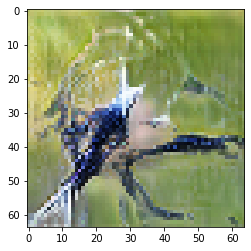

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 14

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.39607310295105 sec
Gen loss: 1.5403761689255877, Disc loss: 0.9958483967677687, Disc real loss: 0.507289817581978, Disc fake loss: 0.48855857732819347
Time for epoch 2 is 13.38997483253479 sec
Gen loss: 1.563456676839813, Disc loss: 0.9887174406671911, Disc real loss: 0.5015469392544532, Disc fake loss: 0.48717050302804
Time for epoch 3 is 13.399534702301025 sec
Gen loss: 1.5294600896395965, Disc loss: 1.0031336098505552, Disc real loss: 0.5075582629296838, Disc fake loss: 0.49557534579016005
Time for epoch 4 is 13.453344821929932 sec
Gen loss: 1.5354211588862143, Disc loss: 0.9937536404707891, Disc real loss: 0.5061629330562706, Disc fake loss: 0.48759070660686754
Time for epoch 5 is 13.398509502410889 sec
Gen loss: 1.584879511417089, Disc loss: 0.9821763728369219, Disc real loss: 0.498440717940085, Disc fake loss: 0.48373565461415907
Time for epo

Time for epoch 48 is 13.351163148880005 sec
Gen loss: 1.530685479401896, Disc loss: 0.9958777564974012, Disc real loss: 0.5086947971081669, Disc fake loss: 0.4871829596315296
Time for epoch 49 is 13.516601085662842 sec
Gen loss: 1.5709734499292969, Disc loss: 0.991691178261103, Disc real loss: 0.5004432932713491, Disc fake loss: 0.4912478837378949
Time for epoch 50 is 13.356005907058716 sec
Gen loss: 1.5155252709298277, Disc loss: 0.9918845964641105, Disc real loss: 0.5063439195718222, Disc fake loss: 0.48554067794223466
Time for epoch 51 is 13.34894347190857 sec
Gen loss: 1.5276520510676108, Disc loss: 1.002744244204627, Disc real loss: 0.5098497766627852, Disc fake loss: 0.49289446713801643
Time for epoch 52 is 13.345040082931519 sec
Gen loss: 1.5270154789534365, Disc loss: 0.9991155998493598, Disc real loss: 0.5078957789958654, Disc fake loss: 0.49121981778442053
Time for epoch 53 is 13.419847965240479 sec
Gen loss: 1.5278364258406931, Disc loss: 0.9982540450768096, Disc real loss: 

Time for epoch 95 is 13.324950456619263 sec
Gen loss: 1.5181779993904962, Disc loss: 0.9955165455657938, Disc real loss: 0.5110964901886659, Disc fake loss: 0.48442005408488636
Time for epoch 96 is 13.508491516113281 sec
Gen loss: 1.521646226970807, Disc loss: 1.0009530653475422, Disc real loss: 0.5098600284193913, Disc fake loss: 0.4910930343436678
Time for epoch 97 is 13.387144804000854 sec
Gen loss: 1.53379884160308, Disc loss: 0.9973042119486222, Disc real loss: 0.50747257794145, Disc fake loss: 0.4898316331995212
Time for epoch 98 is 13.377671003341675 sec
Gen loss: 1.534470085529131, Disc loss: 0.9990113905774869, Disc real loss: 0.5066452058673228, Disc fake loss: 0.49236618398327814
Time for epoch 99 is 13.36432409286499 sec
Gen loss: 1.5390841053107243, Disc loss: 0.9906836980726661, Disc real loss: 0.5069739470475412, Disc fake loss: 0.4837097504597692
Time for epoch 100 is 13.433470726013184 sec
Gen loss: 1.5406626882914929, Disc loss: 0.9920885225298605, Disc real loss: 0.5

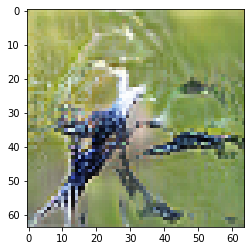

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 15

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.485824346542358 sec
Gen loss: 1.539569236075652, Disc loss: 0.99799892847454, Disc real loss: 0.5074146856783528, Disc fake loss: 0.49058424110012
Time for epoch 2 is 13.313471555709839 sec
Gen loss: 1.5260788997014363, Disc loss: 1.001187319031899, Disc real loss: 0.5108924537170224, Disc fake loss: 0.4902948664455879
Time for epoch 3 is 13.551799058914185 sec
Gen loss: 1.540571550043618, Disc loss: 1.0010401495103913, Disc real loss: 0.5106243071194264, Disc fake loss: 0.49041584400626703
Time for epoch 4 is 13.478080749511719 sec
Gen loss: 1.5236437572696344, Disc loss: 0.9973425525959915, Disc real loss: 0.5090835293941705, Disc fake loss: 0.4882590253017136
Time for epoch 5 is 13.316601276397705 sec
Gen loss: 1.5428298395177535, Disc loss: 0.9940614731008122, Disc real loss: 0.5071860335383634, Disc fake loss: 0.48687544190463655
Time for epoc

Time for epoch 47 is 13.476785659790039 sec
Gen loss: 1.4873235354901653, Disc loss: 1.0120886048973414, Disc real loss: 0.5175582335247257, Disc fake loss: 0.49453037226103186
Time for epoch 48 is 13.317310810089111 sec
Gen loss: 1.5220225454992071, Disc loss: 0.9980387083560147, Disc real loss: 0.50837405611506, Disc fake loss: 0.489664650867948
Time for epoch 49 is 13.407767295837402 sec
Gen loss: 1.529785297427397, Disc loss: 0.9990432420720253, Disc real loss: 0.508972132109045, Disc fake loss: 0.4900711103668058
Time for epoch 50 is 13.40652084350586 sec
Gen loss: 1.515147181707346, Disc loss: 0.9960732358257945, Disc real loss: 0.5081277978291033, Disc fake loss: 0.487945437835161
Time for epoch 51 is 13.425118446350098 sec
Gen loss: 1.5231111876686738, Disc loss: 1.0014431298909794, Disc real loss: 0.512017409329815, Disc fake loss: 0.4894257205611645
Time for epoch 52 is 13.407570362091064 sec
Gen loss: 1.5402007161117182, Disc loss: 0.9976441299689172, Disc real loss: 0.51069

Time for epoch 94 is 13.387733221054077 sec
Gen loss: 1.5213909401157037, Disc loss: 1.0028408418502912, Disc real loss: 0.5113028321001265, Disc fake loss: 0.4915380095078693
Time for epoch 95 is 13.378562688827515 sec
Gen loss: 1.5312939814435758, Disc loss: 0.9921752178895118, Disc real loss: 0.506968588686894, Disc fake loss: 0.48520663106021517
Time for epoch 96 is 13.39081597328186 sec
Gen loss: 1.5425276016478293, Disc loss: 0.9962124296320163, Disc real loss: 0.508662089180494, Disc fake loss: 0.4875503423091196
Time for epoch 97 is 13.385894060134888 sec
Gen loss: 1.5235343709547668, Disc loss: 1.0009838555886494, Disc real loss: 0.5101610808191583, Disc fake loss: 0.4908227754156118
Time for epoch 98 is 13.382573127746582 sec
Gen loss: 1.5385788142842651, Disc loss: 0.9951514485405712, Disc real loss: 0.5086586600558222, Disc fake loss: 0.48649278654638667
Time for epoch 99 is 13.3865807056427 sec
Gen loss: 1.5456384026261203, Disc loss: 1.0005137510092923, Disc real loss: 0.

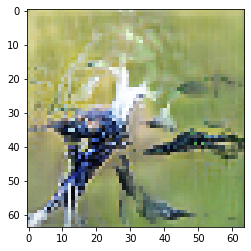

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 16

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.414812326431274 sec
Gen loss: 1.5347380150301346, Disc loss: 0.9937740410892622, Disc real loss: 0.5056845101560681, Disc fake loss: 0.48808952996401284
Time for epoch 2 is 13.386204957962036 sec
Gen loss: 1.528235274601758, Disc loss: 1.0049945988306186, Disc real loss: 0.5138672318077346, Disc fake loss: 0.4911273656498772
Time for epoch 3 is 13.397479772567749 sec
Gen loss: 1.5518211937209132, Disc loss: 0.9970314362184788, Disc real loss: 0.5062377780756653, Disc fake loss: 0.4907936583043437
Time for epoch 4 is 13.379706859588623 sec
Gen loss: 1.5308898974886431, Disc loss: 0.9987230202369897, Disc real loss: 0.5089403525762118, Disc fake loss: 0.4897826683068986
Time for epoch 5 is 13.385634660720825 sec
Gen loss: 1.541230163923124, Disc loss: 0.9871803688486094, Disc real loss: 0.5030345001679449, Disc fake loss: 0.48414587021520145
Time for

Time for epoch 48 is 13.321545600891113 sec
Gen loss: 1.5602467031013676, Disc loss: 1.0012048292289257, Disc real loss: 0.507852000272694, Disc fake loss: 0.49335283065229896
Time for epoch 49 is 13.314046144485474 sec
Gen loss: 1.5277934416845884, Disc loss: 0.9938953711088434, Disc real loss: 0.5094149499566252, Disc fake loss: 0.48448041953691623
Time for epoch 50 is 13.353323221206665 sec
Gen loss: 1.5209760281451672, Disc loss: 0.9996773329207568, Disc real loss: 0.5092468838381573, Disc fake loss: 0.49043044859800883
Time for epoch 51 is 13.472819089889526 sec
Gen loss: 1.5237972671746562, Disc loss: 1.0016011954323063, Disc real loss: 0.5085827114620829, Disc fake loss: 0.4930184837279281
Time for epoch 52 is 13.333893537521362 sec
Gen loss: 1.5402249256123695, Disc loss: 0.9979122851276139, Disc real loss: 0.5095465365787185, Disc fake loss: 0.48836574822583495
Time for epoch 53 is 13.389561891555786 sec
Gen loss: 1.5288459359791866, Disc loss: 1.0052912987990754, Disc real lo

Time for epoch 95 is 13.473207950592041 sec
Gen loss: 1.5456104659775731, Disc loss: 0.9887875336295544, Disc real loss: 0.4995429336540098, Disc fake loss: 0.4892445996524842
Time for epoch 96 is 13.298139095306396 sec
Gen loss: 1.5270944035796292, Disc loss: 1.0005709679146124, Disc real loss: 0.5098184321307877, Disc fake loss: 0.4907525376414219
Time for epoch 97 is 13.409045457839966 sec
Gen loss: 1.5316922089594813, Disc loss: 1.0031871697120873, Disc real loss: 0.5090479963032534, Disc fake loss: 0.4941391721973574
Time for epoch 98 is 13.397160530090332 sec
Gen loss: 1.5315707233863147, Disc loss: 1.000598417065008, Disc real loss: 0.5093561485207824, Disc fake loss: 0.4912422692711114
Time for epoch 99 is 13.420709371566772 sec
Gen loss: 1.5442478608309738, Disc loss: 0.9913986428643307, Disc real loss: 0.5026713639578522, Disc fake loss: 0.48872727850265296
Time for epoch 100 is 13.42070722579956 sec
Gen loss: 1.6216330654252835, Disc loss: 0.9784501278949623, Disc real loss:

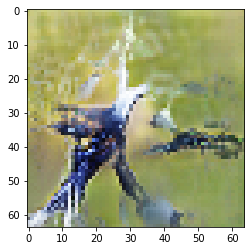

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 17

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.406955003738403 sec
Gen loss: 1.5163634501821626, Disc loss: 1.0023338533029325, Disc real loss: 0.5104996959368387, Disc fake loss: 0.4918341570430332
Time for epoch 2 is 13.399121046066284 sec
Gen loss: 1.537658399682704, Disc loss: 0.9970791543402323, Disc real loss: 0.509357999091549, Disc fake loss: 0.4877211552486833
Time for epoch 3 is 13.39293122291565 sec
Gen loss: 1.5385322893861186, Disc loss: 0.9972158949872666, Disc real loss: 0.5067137776997678, Disc fake loss: 0.4905021139761297
Time for epoch 4 is 13.390829086303711 sec
Gen loss: 1.5127581089815796, Disc loss: 1.0060036411776452, Disc real loss: 0.5130764634467075, Disc fake loss: 0.4929271766002262
Time for epoch 5 is 13.402113437652588 sec
Gen loss: 1.5576784452448693, Disc loss: 0.9948454609085228, Disc real loss: 0.5058933725848107, Disc fake loss: 0.48895208767759124
Time for e

Time for epoch 48 is 13.348068952560425 sec
Gen loss: 1.531519562248292, Disc loss: 1.0046041102267216, Disc real loss: 0.5119913043530007, Disc fake loss: 0.49261280684290215
Time for epoch 49 is 13.488393545150757 sec
Gen loss: 1.5588687086493018, Disc loss: 0.9922102814121299, Disc real loss: 0.5025450130949821, Disc fake loss: 0.48966526944785904
Time for epoch 50 is 13.305225133895874 sec
Gen loss: 1.533361704045841, Disc loss: 0.9904341437629245, Disc real loss: 0.5045697528333845, Disc fake loss: 0.48586438834505674
Time for epoch 51 is 13.372681140899658 sec
Gen loss: 1.525826661567378, Disc loss: 1.00338614778467, Disc real loss: 0.507576723570423, Disc fake loss: 0.49580942526419314
Time for epoch 52 is 13.378770589828491 sec
Gen loss: 1.5332406953098328, Disc loss: 1.0023560270384397, Disc real loss: 0.5129482169461445, Disc fake loss: 0.4894078121114229
Time for epoch 53 is 13.419075965881348 sec
Gen loss: 1.5354663860507127, Disc loss: 0.9974046895497537, Disc real loss: 0

Time for epoch 95 is 13.32863736152649 sec
Gen loss: 1.5267220367261065, Disc loss: 0.9947102221693127, Disc real loss: 0.5087385982032714, Disc fake loss: 0.4859716236429809
Time for epoch 96 is 13.366045236587524 sec
Gen loss: 1.5237435532133108, Disc loss: 1.0021519417039102, Disc real loss: 0.5100254901864019, Disc fake loss: 0.49212645531346805
Time for epoch 97 is 13.526076316833496 sec
Gen loss: 1.534240151162393, Disc loss: 0.9993476866060479, Disc real loss: 0.5087529887674946, Disc fake loss: 0.4905947006653318
Time for epoch 98 is 13.449333429336548 sec
Gen loss: 1.519917178283216, Disc loss: 1.0040139827301833, Disc real loss: 0.5109512611294826, Disc fake loss: 0.49306272216605623
Time for epoch 99 is 13.403788328170776 sec
Gen loss: 1.5453272382741374, Disc loss: 0.9960965187892035, Disc real loss: 0.5053679179450684, Disc fake loss: 0.4907286013691083
Time for epoch 100 is 13.33150053024292 sec
Gen loss: 1.5232717574127321, Disc loss: 0.9989431274292592, Disc real loss: 

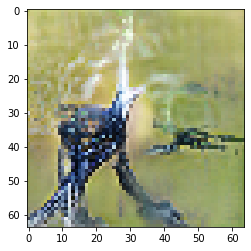

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 18

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.375493288040161 sec
Gen loss: 1.5255947810847585, Disc loss: 1.0024163185096369, Disc real loss: 0.5113565181167468, Disc fake loss: 0.4910597999890645
Time for epoch 2 is 13.386169672012329 sec
Gen loss: 1.5228086684131363, Disc loss: 1.0064876312162818, Disc real loss: 0.5124332589024128, Disc fake loss: 0.4940543705370368
Time for epoch 3 is 13.386807441711426 sec
Gen loss: 1.5343111630700792, Disc loss: 0.9979515815491922, Disc real loss: 0.5102963752055233, Disc fake loss: 0.4876552081205011
Time for epoch 4 is 13.375905275344849 sec
Gen loss: 1.5291447587775666, Disc loss: 1.0034123502449614, Disc real loss: 0.509992852362837, Disc fake loss: 0.49341949772059435
Time for epoch 5 is 13.375815391540527 sec
Gen loss: 1.5412859202723517, Disc loss: 0.9860573604824098, Disc real loss: 0.5007623338763952, Disc fake loss: 0.48529502700983995
Time fo

Time for epoch 47 is 13.410350799560547 sec
Gen loss: 1.5153321870943395, Disc loss: 1.0036083816835875, Disc real loss: 0.5136984391264153, Disc fake loss: 0.4899099437686486
Time for epoch 48 is 13.314435958862305 sec
Gen loss: 1.5449566130392596, Disc loss: 0.9984947661074196, Disc real loss: 0.5111507416417606, Disc fake loss: 0.4873440244656591
Time for epoch 49 is 13.454991340637207 sec
Gen loss: 1.5358084000869172, Disc loss: 1.002256321551677, Disc real loss: 0.5098427659289301, Disc fake loss: 0.49241355384591473
Time for epoch 50 is 13.452017545700073 sec
Gen loss: 1.5288067513365087, Disc loss: 0.9935035576342244, Disc real loss: 0.5069735799701556, Disc fake loss: 0.48652997532188086
Time for epoch 51 is 13.402927160263062 sec
Gen loss: 1.5444928779188534, Disc loss: 0.9966623726576002, Disc real loss: 0.5057300859431264, Disc fake loss: 0.4909322890970442
Time for epoch 52 is 13.371480703353882 sec
Gen loss: 1.5342949732209286, Disc loss: 1.00275012131952, Disc real loss: 

Time for epoch 94 is 13.338373184204102 sec
Gen loss: 1.5321714739166301, Disc loss: 1.002560610047524, Disc real loss: 0.5109367107311238, Disc fake loss: 0.49162390149705776
Time for epoch 95 is 13.478288412094116 sec
Gen loss: 1.5655074410322236, Disc loss: 0.9934999461419537, Disc real loss: 0.5062610671772221, Disc fake loss: 0.4872388817511277
Time for epoch 96 is 13.36965274810791 sec
Gen loss: 1.5194280951972898, Disc loss: 1.0044858421736615, Disc real loss: 0.5119194109749988, Disc fake loss: 0.49256643071407225
Time for epoch 97 is 13.35482382774353 sec
Gen loss: 1.5278539360377201, Disc loss: 1.004016400352726, Disc real loss: 0.5095589311142278, Disc fake loss: 0.49445746907696814
Time for epoch 98 is 13.376632690429688 sec
Gen loss: 1.5347483319641775, Disc loss: 1.0021201097545263, Disc real loss: 0.5101088520876438, Disc fake loss: 0.49201125560737236
Time for epoch 99 is 13.539687633514404 sec
Gen loss: 1.5314764472527234, Disc loss: 1.0059137473584514, Disc real loss:

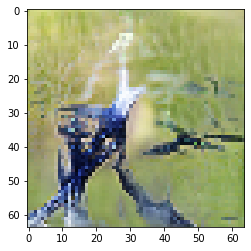

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 19

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.334105968475342 sec
Gen loss: 1.5375561064820948, Disc loss: 1.0008414056566026, Disc real loss: 0.5080595202239225, Disc fake loss: 0.4927818843827338
Time for epoch 2 is 13.542444229125977 sec
Gen loss: 1.5333099988740957, Disc loss: 1.0038112384193958, Disc real loss: 0.5094752657381176, Disc fake loss: 0.4943359713082714
Time for epoch 3 is 13.332068681716919 sec
Gen loss: 1.5614494334068403, Disc loss: 0.9921407090616097, Disc real loss: 0.502922603956406, Disc fake loss: 0.4892181028841634
Time for epoch 4 is 13.470398902893066 sec
Gen loss: 1.5357319578568787, Disc loss: 0.9993661625921565, Disc real loss: 0.5097177539091446, Disc fake loss: 0.48964840674464943
Time for epoch 5 is 13.422497749328613 sec
Gen loss: 1.5144694504052967, Disc loss: 1.001483604675386, Disc real loss: 0.5091081166332007, Disc fake loss: 0.49237548683070875
Time for

Time for epoch 48 is 13.392449378967285 sec
Gen loss: 1.5268480406221012, Disc loss: 1.006348344207133, Disc real loss: 0.5154529292247483, Disc fake loss: 0.4908954154669754
Time for epoch 49 is 13.385969400405884 sec
Gen loss: 1.5248921017659711, Disc loss: 1.0062789477630036, Disc real loss: 0.5112481861902769, Disc fake loss: 0.49503076375338445
Time for epoch 50 is 13.440603256225586 sec
Gen loss: 1.5267391198372777, Disc loss: 0.998841729429033, Disc real loss: 0.5093033409054041, Disc fake loss: 0.4895383913504076
Time for epoch 51 is 13.39449429512024 sec
Gen loss: 1.5381866221828513, Disc loss: 1.0007420904268094, Disc real loss: 0.5094540182167921, Disc fake loss: 0.49128807245231254
Time for epoch 52 is 13.390841722488403 sec
Gen loss: 1.5387635221326255, Disc loss: 0.9997868970803775, Disc real loss: 0.5058832976230114, Disc fake loss: 0.49390360026501706
Time for epoch 53 is 13.388479471206665 sec
Gen loss: 1.5361278483538123, Disc loss: 1.0024591695648546, Disc real loss:

Time for epoch 95 is 13.427497386932373 sec
Gen loss: 1.5373638125292977, Disc loss: 0.991002144206184, Disc real loss: 0.5040035934306095, Disc fake loss: 0.4869985531177624
Time for epoch 96 is 13.395147562026978 sec
Gen loss: 1.5473461202812713, Disc loss: 1.0027642886490034, Disc real loss: 0.5081520897909232, Disc fake loss: 0.49461219748507346
Time for epoch 97 is 13.392019510269165 sec
Gen loss: 1.5268404480564561, Disc loss: 1.0014583610583774, Disc real loss: 0.5114156776650488, Disc fake loss: 0.49004268452403993
Time for epoch 98 is 13.38280725479126 sec
Gen loss: 1.5361133209735074, Disc loss: 0.9991489001082857, Disc real loss: 0.5068863442919764, Disc fake loss: 0.49226255452406764
Time for epoch 99 is 13.409589052200317 sec
Gen loss: 1.544289860945084, Disc loss: 1.0000280437430715, Disc real loss: 0.5088026229605119, Disc fake loss: 0.49122541819807636
Time for epoch 100 is 13.361652851104736 sec
Gen loss: 1.528412567567696, Disc loss: 0.9934684364453241, Disc real loss

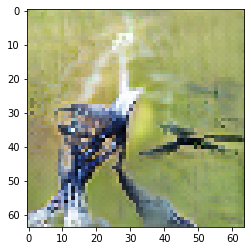

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 20

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.3782639503479 sec
Gen loss: 1.535206189969691, Disc loss: 1.0068149082059783, Disc real loss: 0.5094668200507073, Disc fake loss: 0.49734808847833134
Time for epoch 2 is 13.378466606140137 sec
Gen loss: 1.5392955005330444, Disc loss: 0.9950908608229826, Disc real loss: 0.5051555096456998, Disc fake loss: 0.4899353502081016
Time for epoch 3 is 13.384251832962036 sec
Gen loss: 1.5379526586067387, Disc loss: 1.0038270139435765, Disc real loss: 0.5109611168140318, Disc fake loss: 0.49286589729107494
Time for epoch 4 is 13.42181134223938 sec
Gen loss: 1.524657335061691, Disc loss: 1.0031638804490004, Disc real loss: 0.5105724516438275, Disc fake loss: 0.4925914279167568
Time for epoch 5 is 13.382787227630615 sec
Gen loss: 1.5401298146906908, Disc loss: 0.9945392224200695, Disc real loss: 0.5029834007344595, Disc fake loss: 0.49155581918189195
Time for e

Time for epoch 48 is 13.476369857788086 sec
Gen loss: 1.5399480492765019, Disc loss: 0.9999568158695045, Disc real loss: 0.508274186271316, Disc fake loss: 0.4916826295174234
Time for epoch 49 is 13.523090839385986 sec
Gen loss: 1.5317074396422885, Disc loss: 1.002410106704164, Disc real loss: 0.5117274483206472, Disc fake loss: 0.49068265692974494
Time for epoch 50 is 13.346099853515625 sec
Gen loss: 1.526120738285344, Disc loss: 1.0027161812394616, Disc real loss: 0.5072852146980885, Disc fake loss: 0.4954309675105542
Time for epoch 51 is 13.344774723052979 sec
Gen loss: 1.5403160263852376, Disc loss: 0.9947025296164722, Disc real loss: 0.5047622770474856, Disc fake loss: 0.4899402533766377
Time for epoch 52 is 13.489816904067993 sec
Gen loss: 1.531709141847564, Disc loss: 1.0041288664024375, Disc real loss: 0.5108218279472858, Disc fake loss: 0.4933070392628026
Time for epoch 53 is 13.362060308456421 sec
Gen loss: 1.54345837841189, Disc loss: 1.0013649462038263, Disc real loss: 0.51

Time for epoch 95 is 13.465975761413574 sec
Gen loss: 1.5403428119695606, Disc loss: 0.9970602649983352, Disc real loss: 0.5049459683862805, Disc fake loss: 0.49211429418910163
Time for epoch 96 is 13.396324157714844 sec
Gen loss: 1.5235457006831803, Disc loss: 1.0034943256920916, Disc real loss: 0.5080838049168832, Disc fake loss: 0.4954105223905103
Time for epoch 97 is 13.304577112197876 sec
Gen loss: 1.5836741501076759, Disc loss: 0.9949193084789162, Disc real loss: 0.5021831045144296, Disc fake loss: 0.49273620210688934
Time for epoch 98 is 13.444092988967896 sec
Gen loss: 1.5272933302856073, Disc loss: 1.001727092395307, Disc real loss: 0.5096794442755743, Disc fake loss: 0.4920476481197326
Time for epoch 99 is 13.336943626403809 sec
Gen loss: 1.5215897976867552, Disc loss: 1.0074037116394456, Disc real loss: 0.5122614808198882, Disc fake loss: 0.49514223413092656
Time for epoch 100 is 13.34327745437622 sec
Gen loss: 1.5300725650012008, Disc loss: 1.0038423305604516, Disc real los

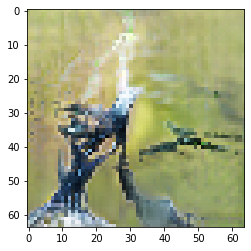

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 21

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.53081727027893 sec
Gen loss: 1.5208326969043349, Disc loss: 1.0050963767498813, Disc real loss: 0.5093273209524025, Disc fake loss: 0.49576905531288806
Time for epoch 2 is 13.35876202583313 sec
Gen loss: 1.54081929537662, Disc loss: 0.9996734893095849, Disc real loss: 0.5086547872076835, Disc fake loss: 0.491018701859606
Time for epoch 3 is 13.458060026168823 sec
Gen loss: 1.5428488005790606, Disc loss: 1.00596578205181, Disc real loss: 0.5083886403539962, Disc fake loss: 0.49757714129398833
Time for epoch 4 is 13.43248176574707 sec
Gen loss: 1.5325156359814693, Disc loss: 0.9991285576406856, Disc real loss: 0.5048660485725093, Disc fake loss: 0.4942625056760421
Time for epoch 5 is 13.375861167907715 sec
Gen loss: 1.5314499265779324, Disc loss: 0.9962769468948447, Disc real loss: 0.504620215434046, Disc fake loss: 0.49165673420681216
Time for epoch

Time for epoch 48 is 13.295997619628906 sec
Gen loss: 1.5312744230435793, Disc loss: 1.0065687361771498, Disc real loss: 0.5129190769783527, Disc fake loss: 0.49364965734119987
Time for epoch 49 is 13.436967849731445 sec
Gen loss: 1.530647466499308, Disc loss: 1.002536179412025, Disc real loss: 0.5099282289746654, Disc fake loss: 0.4926079509219503
Time for epoch 50 is 13.443451166152954 sec
Gen loss: 1.5363813842215188, Disc loss: 1.0002719411035863, Disc real loss: 0.5090003522430978, Disc fake loss: 0.4912715866798308
Time for epoch 51 is 13.382854461669922 sec
Gen loss: 1.5298653020445248, Disc loss: 1.0067272877628564, Disc real loss: 0.5099791012159208, Disc fake loss: 0.4967481883237678
Time for epoch 52 is 13.36720895767212 sec
Gen loss: 1.533006928477507, Disc loss: 1.0002903886603791, Disc real loss: 0.5078853808121306, Disc fake loss: 0.49240500679830224
Time for epoch 53 is 13.389228582382202 sec
Gen loss: 1.5388894801540427, Disc loss: 0.9992664803657428, Disc real loss: 0

Time for epoch 95 is 13.468767404556274 sec
Gen loss: 1.5335407903200888, Disc loss: 0.997045212967932, Disc real loss: 0.5070887405051772, Disc fake loss: 0.4899564726242851
Time for epoch 96 is 13.379153728485107 sec
Gen loss: 1.54385771757865, Disc loss: 1.0000646233881716, Disc real loss: 0.5081489750040256, Disc fake loss: 0.49191564402283044
Time for epoch 97 is 13.365069389343262 sec
Gen loss: 1.5363721889532032, Disc loss: 1.0013036639063662, Disc real loss: 0.5077913656305815, Disc fake loss: 0.4935123006987378
Time for epoch 98 is 13.380355596542358 sec
Gen loss: 1.5423431222031756, Disc loss: 1.003944063735848, Disc real loss: 0.5093800470757937, Disc fake loss: 0.49456401730617533
Time for epoch 99 is 13.369246006011963 sec
Gen loss: 1.52820014727471, Disc loss: 1.0037687574298724, Disc real loss: 0.5103331167038864, Disc fake loss: 0.4934356418566975
Time for epoch 100 is 13.373854875564575 sec
Gen loss: 1.5352055755087999, Disc loss: 0.9958741514663386, Disc real loss: 0.

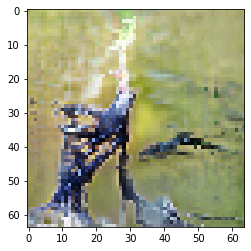

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 22

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.400063276290894 sec
Gen loss: 1.5343234700562185, Disc loss: 1.0042385413717771, Disc real loss: 0.5094805821816772, Disc fake loss: 0.4947579602400462
Time for epoch 2 is 13.375519514083862 sec
Gen loss: 1.5496389187448394, Disc loss: 0.9978948477807084, Disc real loss: 0.5092426304248613, Disc fake loss: 0.488652216548196
Time for epoch 3 is 13.489610433578491 sec
Gen loss: 1.5265020665114488, Disc loss: 0.9981192114553478, Disc real loss: 0.504437743729046, Disc fake loss: 0.4936814689377782
Time for epoch 4 is 13.35760760307312 sec
Gen loss: 1.5505656307628808, Disc loss: 1.0003472529452668, Disc real loss: 0.5052492333056158, Disc fake loss: 0.49509801863008723
Time for epoch 5 is 13.364149332046509 sec
Gen loss: 1.5250776033737472, Disc loss: 0.9961075107579632, Disc real loss: 0.510696745500332, Disc fake loss: 0.4854107648538057
Time for ep

Time for epoch 48 is 13.373150110244751 sec
Gen loss: 1.5374015424309708, Disc loss: 1.0050751776876166, Disc real loss: 0.5111698092322362, Disc fake loss: 0.493905370636038
Time for epoch 49 is 13.37360405921936 sec
Gen loss: 1.5307705686667423, Disc loss: 1.0030009908081716, Disc real loss: 0.5096826119636132, Disc fake loss: 0.4933183790060886
Time for epoch 50 is 13.388139724731445 sec
Gen loss: 1.5460416734380127, Disc loss: 0.9972951840255965, Disc real loss: 0.5067892185233149, Disc fake loss: 0.4905059644523352
Time for epoch 51 is 13.378747701644897 sec
Gen loss: 1.5196230763665384, Disc loss: 1.0064751336245032, Disc real loss: 0.5114299545120095, Disc fake loss: 0.495045178466373
Time for epoch 52 is 13.378231048583984 sec
Gen loss: 1.540576432455523, Disc loss: 0.9998167430159199, Disc real loss: 0.5048095503150609, Disc fake loss: 0.4950071895510201
Time for epoch 53 is 13.424287557601929 sec
Gen loss: 1.5360612236064302, Disc loss: 1.0064570238273642, Disc real loss: 0.5

Time for epoch 95 is 13.437657356262207 sec
Gen loss: 1.5466665850099186, Disc loss: 0.9949458377148078, Disc real loss: 0.5054000101599913, Disc fake loss: 0.48954583191613193
Time for epoch 96 is 13.433813095092773 sec
Gen loss: 1.5331956112610938, Disc loss: 0.9994266020250191, Disc real loss: 0.5085916195296982, Disc fake loss: 0.4908349839490927
Time for epoch 97 is 13.321056127548218 sec
Gen loss: 1.5454679905237545, Disc loss: 1.001579912858927, Disc real loss: 0.5087763194630786, Disc fake loss: 0.49280359266896234
Time for epoch 98 is 13.428075313568115 sec
Gen loss: 1.5352231092892366, Disc loss: 1.0041335202491057, Disc real loss: 0.5110335688442396, Disc fake loss: 0.49309995447394
Time for epoch 99 is 13.477950096130371 sec
Gen loss: 1.5424234075597953, Disc loss: 0.9980077585230674, Disc real loss: 0.506345168442584, Disc fake loss: 0.49166259428026876
Time for epoch 100 is 13.442918300628662 sec
Gen loss: 1.5422393070649971, Disc loss: 0.9954611227764347, Disc real loss:

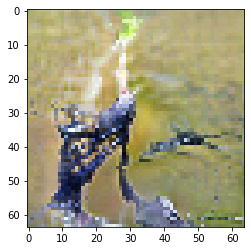

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 23

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.364436626434326 sec
Gen loss: 1.538580762338509, Disc loss: 1.0007405542745822, Disc real loss: 0.511833509213233, Disc fake loss: 0.4889070432037519
Time for epoch 2 is 13.313615322113037 sec
Gen loss: 1.5631862788342525, Disc loss: 0.9979865749677023, Disc real loss: 0.5039587741298728, Disc fake loss: 0.4940278022916013
Time for epoch 3 is 13.519117593765259 sec
Gen loss: 1.52686590295497, Disc loss: 1.0061430911707685, Disc real loss: 0.5096415190031212, Disc fake loss: 0.4965015740252446
Time for epoch 4 is 13.371495962142944 sec
Gen loss: 1.527675046507259, Disc loss: 1.0081068530961428, Disc real loss: 0.5117795704826107, Disc fake loss: 0.4963272807559347
Time for epoch 5 is 13.435852766036987 sec
Gen loss: 1.5188706528526659, Disc loss: 1.0003791957043697, Disc real loss: 0.5076115123301663, Disc fake loss: 0.4927676829703778
Time for epoc

Time for epoch 48 is 13.375306844711304 sec
Gen loss: 1.5288061006928524, Disc loss: 1.009355425188535, Disc real loss: 0.5110538849824167, Disc fake loss: 0.49830153689474915
Time for epoch 49 is 13.397418022155762 sec
Gen loss: 1.52715777478567, Disc loss: 1.0041992644953535, Disc real loss: 0.5072497539727022, Disc fake loss: 0.49694951116877195
Time for epoch 50 is 13.379380941390991 sec
Gen loss: 1.5358805265530016, Disc loss: 0.9940412070369979, Disc real loss: 0.5022068639111713, Disc fake loss: 0.49183434336812193
Time for epoch 51 is 13.367865085601807 sec
Gen loss: 1.5399141234111011, Disc loss: 1.0096450973009352, Disc real loss: 0.5126006011232774, Disc fake loss: 0.49704449658148336
Time for epoch 52 is 13.374614000320435 sec
Gen loss: 1.5262979391790663, Disc loss: 1.0004521561508903, Disc real loss: 0.5084152974410432, Disc fake loss: 0.49203685992132357
Time for epoch 53 is 13.453125715255737 sec
Gen loss: 1.5421997544565176, Disc loss: 1.0038541565096475, Disc real los

Time for epoch 95 is 13.354569673538208 sec
Gen loss: 1.5313619061860289, Disc loss: 0.9949665591322633, Disc real loss: 0.5067456502739976, Disc fake loss: 0.4882209103928026
Time for epoch 96 is 13.350143432617188 sec
Gen loss: 1.5310473778060458, Disc loss: 1.0096996575190123, Disc real loss: 0.51172719140686, Disc fake loss: 0.4979724658294745
Time for epoch 97 is 13.368582010269165 sec
Gen loss: 1.5232563939520982, Disc loss: 1.0096233974950424, Disc real loss: 0.5123648870443587, Disc fake loss: 0.4972585084315561
Time for epoch 98 is 13.392610311508179 sec
Gen loss: 1.5401566264429067, Disc loss: 1.00010937210021, Disc real loss: 0.5080964028996827, Disc fake loss: 0.4920129689582318
Time for epoch 99 is 13.352222204208374 sec
Gen loss: 1.563739083000638, Disc loss: 1.0062323039786278, Disc real loss: 0.5093383524152968, Disc fake loss: 0.4968939528555728
Time for epoch 100 is 13.36882996559143 sec
Gen loss: 1.5296840538500447, Disc loss: 0.9952521450151273, Disc real loss: 0.50

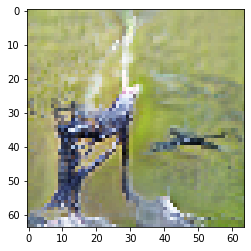

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 24

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.352975368499756 sec
Gen loss: 1.543477121730484, Disc loss: 0.9968050566469104, Disc real loss: 0.502067105395361, Disc fake loss: 0.49473795310914676
Time for epoch 2 is 13.425283193588257 sec
Gen loss: 1.516789061590262, Disc loss: 1.012690977029361, Disc real loss: 0.5157267598278801, Disc fake loss: 0.4969642172822461
Time for epoch 3 is 13.320945978164673 sec
Gen loss: 1.5297383554582673, Disc loss: 1.0016657703614171, Disc real loss: 0.5074500478703156, Disc fake loss: 0.49421572451022905
Time for epoch 4 is 13.372802495956421 sec
Gen loss: 1.542847003394026, Disc loss: 0.9983072043434391, Disc real loss: 0.50725699795617, Disc fake loss: 0.49105020549885303
Time for epoch 5 is 13.452125072479248 sec
Gen loss: 1.5347057962159154, Disc loss: 1.0025906293049738, Disc real loss: 0.5078367836430144, Disc fake loss: 0.49475384614654994
Time for ep

Time for epoch 48 is 13.392935037612915 sec
Gen loss: 1.5299120349935722, Disc loss: 1.0124588332525113, Disc real loss: 0.5155289418652129, Disc fake loss: 0.4969298906604126
Time for epoch 49 is 13.376858949661255 sec
Gen loss: 1.5358994414166707, Disc loss: 1.0030965821206732, Disc real loss: 0.5088389351923615, Disc fake loss: 0.49425765040121106
Time for epoch 50 is 13.373224020004272 sec
Gen loss: 1.528576669654226, Disc loss: 0.9969398815457414, Disc real loss: 0.5064063283001504, Disc fake loss: 0.4905335558300742
Time for epoch 51 is 13.381996870040894 sec
Gen loss: 1.5557792118894376, Disc loss: 0.9997437436406206, Disc real loss: 0.5076190545791532, Disc fake loss: 0.4921246915651854
Time for epoch 52 is 13.42437195777893 sec
Gen loss: 1.5746534797880385, Disc loss: 1.0024097437457986, Disc real loss: 0.5026464543853025, Disc fake loss: 0.49976329210650955
Time for epoch 53 is 13.377345323562622 sec
Gen loss: 1.504100845112064, Disc loss: 1.0065436172614575, Disc real loss: 

Time for epoch 95 is 13.433714151382446 sec
Gen loss: 1.5340918577137355, Disc loss: 0.9993093929639677, Disc real loss: 0.5074042634266179, Disc fake loss: 0.4919051299411753
Time for epoch 96 is 13.437068939208984 sec
Gen loss: 1.5267230847340612, Disc loss: 1.004687065516061, Disc real loss: 0.5092981297795366, Disc fake loss: 0.4953889358980546
Time for epoch 97 is 13.472732782363892 sec
Gen loss: 1.5404295475502325, Disc loss: 1.0033462795461743, Disc real loss: 0.5097620742430855, Disc fake loss: 0.4935842078068069
Time for epoch 98 is 13.38475775718689 sec
Gen loss: 1.5443535183826436, Disc loss: 1.0030290161368, Disc real loss: 0.5108190824991965, Disc fake loss: 0.49220993759509346
Time for epoch 99 is 13.330679893493652 sec
Gen loss: 1.5285157401387284, Disc loss: 1.0071326306841883, Disc real loss: 0.5112759401481649, Disc fake loss: 0.4958566908590839
Time for epoch 100 is 13.50211215019226 sec
Gen loss: 1.522486541652421, Disc loss: 1.0047664768327542, Disc real loss: 0.51

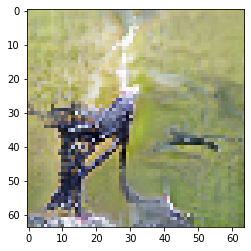

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 25

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.36124300956726 sec
Gen loss: 1.5330080669423751, Disc loss: 1.0039193308773402, Disc real loss: 0.5115287240927782, Disc fake loss: 0.4923906073499178
Time for epoch 2 is 13.272745132446289 sec
Gen loss: 1.5351372624477397, Disc loss: 0.9997536052210221, Disc real loss: 0.5086749895478329, Disc fake loss: 0.4910786193883839
Time for epoch 3 is 13.400380373001099 sec
Gen loss: 1.5251354063106424, Disc loss: 1.0108045875864624, Disc real loss: 0.5150960867967063, Disc fake loss: 0.4957085027281185
Time for epoch 4 is 13.45711350440979 sec
Gen loss: 1.537460118774476, Disc loss: 1.0008856639629458, Disc real loss: 0.5054356721520101, Disc fake loss: 0.49544999189170075
Time for epoch 5 is 13.372853994369507 sec
Gen loss: 1.5472102346135994, Disc loss: 0.995659530001281, Disc real loss: 0.5050760546350866, Disc fake loss: 0.4905834767392011
Time for ep

Time for epoch 48 is 13.357719421386719 sec
Gen loss: 1.5292995615703304, Disc loss: 1.0082103020453517, Disc real loss: 0.5108276150090908, Disc fake loss: 0.49738268808620734
Time for epoch 49 is 13.531564950942993 sec
Gen loss: 1.534807149956866, Disc loss: 1.0009519317285802, Disc real loss: 0.5072594655723106, Disc fake loss: 0.4936924633294909
Time for epoch 50 is 13.381109237670898 sec
Gen loss: 1.5258609230925397, Disc loss: 1.0054990578150038, Disc real loss: 0.5082966105401677, Disc fake loss: 0.49720244582106427
Time for epoch 51 is 13.296796560287476 sec
Gen loss: 1.5235698090659247, Disc loss: 1.0057434278128916, Disc real loss: 0.5099693206429159, Disc fake loss: 0.495774108946808
Time for epoch 52 is 13.381568908691406 sec
Gen loss: 1.5372064888961916, Disc loss: 1.0036974252077946, Disc real loss: 0.5073750592505706, Disc fake loss: 0.4963223636958011
Time for epoch 53 is 13.431464195251465 sec
Gen loss: 1.543472527811521, Disc loss: 1.001843731900864, Disc real loss: 0

Time for epoch 95 is 13.396570205688477 sec
Gen loss: 1.5250054174645484, Disc loss: 1.002290277138635, Disc real loss: 0.5081864279621662, Disc fake loss: 0.49410384772269705
Time for epoch 96 is 13.351740837097168 sec
Gen loss: 1.5239288861835552, Disc loss: 1.0056213398935996, Disc real loss: 0.5091651432559419, Disc fake loss: 0.4964561965568925
Time for epoch 97 is 13.35875916481018 sec
Gen loss: 1.5215590084148294, Disc loss: 1.0072624169714082, Disc real loss: 0.5115292381626481, Disc fake loss: 0.4957331779203441
Time for epoch 98 is 13.356578826904297 sec
Gen loss: 1.5291569837063632, Disc loss: 1.01051717770455, Disc real loss: 0.5117477861038715, Disc fake loss: 0.4987693910353229
Time for epoch 99 is 13.35238003730774 sec
Gen loss: 1.5307039878555753, Disc loss: 1.005402968827948, Disc real loss: 0.5101781099792418, Disc fake loss: 0.49522485828335044
Time for epoch 100 is 13.354871273040771 sec
Gen loss: 1.5340625057375528, Disc loss: 1.0013703388896416, Disc real loss: 0.

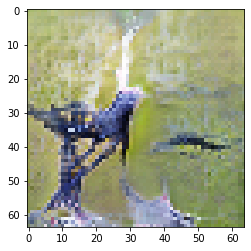

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 26

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.354345560073853 sec
Gen loss: 1.5168632795494101, Disc loss: 1.0114468693087095, Disc real loss: 0.5119935594761598, Disc fake loss: 0.4994533117709121
Time for epoch 2 is 13.350778341293335 sec
Gen loss: 1.5265238711504432, Disc loss: 1.0097208052146724, Disc real loss: 0.5129012313638599, Disc fake loss: 0.496819574173873
Time for epoch 3 is 13.368942499160767 sec
Gen loss: 1.5221501391754564, Disc loss: 1.0092216547588668, Disc real loss: 0.5140877181113896, Disc fake loss: 0.49513393446681947
Time for epoch 4 is 13.406030178070068 sec
Gen loss: 1.5244374007067383, Disc loss: 1.01055133407355, Disc real loss: 0.5128778375099668, Disc fake loss: 0.4976734969674087
Time for epoch 5 is 13.360347986221313 sec
Gen loss: 1.5387368389584508, Disc loss: 0.9948228849628107, Disc real loss: 0.506212738067477, Disc fake loss: 0.4886101464915082
Time for ep

Time for epoch 48 is 13.50889801979065 sec
Gen loss: 1.5202341034483458, Disc loss: 1.0112765886919286, Disc real loss: 0.5155405894043, Disc fake loss: 0.4957359954109037
Time for epoch 49 is 13.444122076034546 sec
Gen loss: 1.5618572118805676, Disc loss: 1.000998444027371, Disc real loss: 0.5065668944905444, Disc fake loss: 0.4944315492137661
Time for epoch 50 is 13.28198528289795 sec
Gen loss: 1.5194404199517517, Disc loss: 1.0005359187681824, Disc real loss: 0.509443780755609, Disc fake loss: 0.49109213946634517
Time for epoch 51 is 13.50746750831604 sec
Gen loss: 1.5239319998397414, Disc loss: 1.0101397875847855, Disc real loss: 0.5113578593827844, Disc fake loss: 0.4987819271520547
Time for epoch 52 is 13.320146083831787 sec
Gen loss: 1.5015578635016753, Disc loss: 1.0136670034106186, Disc real loss: 0.515042962016775, Disc fake loss: 0.4986240385670649
Time for epoch 53 is 13.466990232467651 sec
Gen loss: 1.5419255944125374, Disc loss: 1.0005495247802114, Disc real loss: 0.51076

Time for epoch 95 is 13.281614780426025 sec
Gen loss: 1.526871394335739, Disc loss: 1.0020378781204948, Disc real loss: 0.510713661104683, Disc fake loss: 0.49132421596586545
Time for epoch 96 is 13.44498085975647 sec
Gen loss: 1.5265645105341263, Disc loss: 1.0091499418101013, Disc real loss: 0.5133396465442368, Disc fake loss: 0.4958102970426968
Time for epoch 97 is 13.460415840148926 sec
Gen loss: 1.514509015613132, Disc loss: 1.0097608251300285, Disc real loss: 0.5134394184199129, Disc fake loss: 0.49632140751776654
Time for epoch 98 is 13.328536033630371 sec
Gen loss: 1.533108529682728, Disc loss: 1.0088291134291547, Disc real loss: 0.5127345930916184, Disc fake loss: 0.496094520822127
Time for epoch 99 is 13.323748350143433 sec
Gen loss: 1.521532052900733, Disc loss: 1.0089999621476584, Disc real loss: 0.5088967174533906, Disc fake loss: 0.5001032462288048
Time for epoch 100 is 13.510561466217041 sec
Gen loss: 1.5303051927225377, Disc loss: 0.9958469607642673, Disc real loss: 0.5

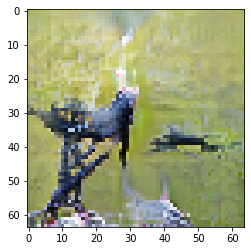

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 27

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.28728437423706 sec
Gen loss: 1.5299218683061884, Disc loss: 1.011723809933598, Disc real loss: 0.5162567014132089, Disc fake loss: 0.49546710924727483
Time for epoch 2 is 13.415927648544312 sec
Gen loss: 1.5269805868143635, Disc loss: 1.0079068300846792, Disc real loss: 0.5117600126479699, Disc fake loss: 0.4961468169521187
Time for epoch 3 is 13.443975687026978 sec
Gen loss: 1.5331277934516347, Disc loss: 1.0029691309140627, Disc real loss: 0.5118369044165624, Disc fake loss: 0.4911322290012184
Time for epoch 4 is 13.39444375038147 sec
Gen loss: 1.525690870556405, Disc loss: 1.0099472610284965, Disc real loss: 0.5139375036647973, Disc fake loss: 0.4960097572829342
Time for epoch 5 is 13.405509948730469 sec
Gen loss: 1.531681297917353, Disc loss: 1.0007205061150115, Disc real loss: 0.5077464742873742, Disc fake loss: 0.4929740319084023
Time for epo

Time for epoch 48 is 13.4036705493927 sec
Gen loss: 1.5215299992057365, Disc loss: 1.0141136137450613, Disc real loss: 0.5170020528117493, Disc fake loss: 0.49711156359856046
Time for epoch 49 is 13.358240365982056 sec
Gen loss: 1.5273638114050474, Disc loss: 1.0066198724395214, Disc real loss: 0.511091186344462, Disc fake loss: 0.49552868569123387
Time for epoch 50 is 13.380346536636353 sec
Gen loss: 1.5443327481830669, Disc loss: 0.994599868127001, Disc real loss: 0.5064491741056365, Disc fake loss: 0.48815069385983434
Time for epoch 51 is 13.377628803253174 sec
Gen loss: 1.5206182901129166, Disc loss: 1.0121433426371111, Disc real loss: 0.5105485921791253, Disc fake loss: 0.5015947486811537
Time for epoch 52 is 13.357775688171387 sec
Gen loss: 1.5319611612697281, Disc loss: 1.0035811541526298, Disc real loss: 0.5118031715797539, Disc fake loss: 0.4917779804729834
Time for epoch 53 is 13.364483833312988 sec
Gen loss: 1.5318398336730998, Disc loss: 1.0022398338408327, Disc real loss: 

Time for epoch 95 is 13.374987840652466 sec
Gen loss: 1.5154341436660064, Disc loss: 1.0034479301796373, Disc real loss: 0.5116303401587778, Disc fake loss: 0.491817591232336
Time for epoch 96 is 13.373181343078613 sec
Gen loss: 1.5426370816502144, Disc loss: 1.0021745489864815, Disc real loss: 0.5073441380892343, Disc fake loss: 0.49483040976653575
Time for epoch 97 is 13.368043899536133 sec
Gen loss: 1.5208835818257112, Disc loss: 1.0113204339655435, Disc real loss: 0.5141359889894966, Disc fake loss: 0.49718444142238233
Time for epoch 98 is 13.378155708312988 sec
Gen loss: 1.524653676402601, Disc loss: 1.0118152279517838, Disc real loss: 0.5163454428759371, Disc fake loss: 0.495469784510491
Time for epoch 99 is 13.366310834884644 sec
Gen loss: 1.5111569631390456, Disc loss: 1.016327495658947, Disc real loss: 0.5152637894722182, Disc fake loss: 0.5010637064290241
Time for epoch 100 is 13.381988525390625 sec
Gen loss: 1.5279091015094663, Disc loss: 0.9997687759761241, Disc real loss: 

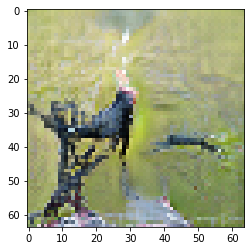

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 28

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.39238977432251 sec
Gen loss: 1.53261742811539, Disc loss: 1.0056295192984708, Disc real loss: 0.5115803142550192, Disc fake loss: 0.49404920399350527
Time for epoch 2 is 13.388495922088623 sec
Gen loss: 1.5232579759789031, Disc loss: 1.0074360549934511, Disc real loss: 0.5108882076533506, Disc fake loss: 0.4965478491169327
Time for epoch 3 is 13.377366781234741 sec
Gen loss: 1.522564939690153, Disc loss: 1.0135898649854065, Disc real loss: 0.5189889591883837, Disc fake loss: 0.4946009053931973
Time for epoch 4 is 13.385336637496948 sec
Gen loss: 1.524649704374918, Disc loss: 1.0044714772927406, Disc real loss: 0.5097364217123688, Disc fake loss: 0.4947350564687879
Time for epoch 5 is 13.366004705429077 sec
Gen loss: 1.5191233565167683, Disc loss: 1.007042663207222, Disc real loss: 0.5097978170809707, Disc fake loss: 0.49724484733772795
Time for epo

Time for epoch 48 is 13.353049278259277 sec
Gen loss: 1.528308664234027, Disc loss: 1.0140054826813985, Disc real loss: 0.51222284998351, Disc fake loss: 0.5017826326978885
Time for epoch 49 is 13.342708349227905 sec
Gen loss: 1.5262811652367032, Disc loss: 1.0088791874689138, Disc real loss: 0.5092074535888061, Disc fake loss: 0.49967173420316807
Time for epoch 50 is 13.366355180740356 sec
Gen loss: 1.530096159717901, Disc loss: 0.9984373484200578, Disc real loss: 0.507948415389229, Disc fake loss: 0.4904889335154195
Time for epoch 51 is 13.354003667831421 sec
Gen loss: 1.5425382216125323, Disc loss: 0.9950674130987669, Disc real loss: 0.505295571838291, Disc fake loss: 0.4897718402912946
Time for epoch 52 is 13.35166883468628 sec
Gen loss: 1.5185922193656445, Disc loss: 1.0134674292915882, Disc real loss: 0.5173690350559669, Disc fake loss: 0.4960983937510307
Time for epoch 53 is 13.356297731399536 sec
Gen loss: 1.5301436234295853, Disc loss: 1.0061498659089976, Disc real loss: 0.511

Time for epoch 95 is 13.42555284500122 sec
Gen loss: 1.518380571833148, Disc loss: 1.0068434903292152, Disc real loss: 0.5103724312168473, Disc fake loss: 0.4964710588700726
Time for epoch 96 is 13.290013551712036 sec
Gen loss: 1.531870723739872, Disc loss: 1.004320649919794, Disc real loss: 0.5105214365291079, Disc fake loss: 0.4937992141175722
Time for epoch 97 is 13.336022853851318 sec
Gen loss: 1.5281541421807556, Disc loss: 1.0089093619568885, Disc real loss: 0.5128965209816206, Disc fake loss: 0.4960128412983282
Time for epoch 98 is 13.442801713943481 sec
Gen loss: 1.545031471304131, Disc loss: 1.0041489563983308, Disc real loss: 0.508559031618966, Disc fake loss: 0.49558992655619694
Time for epoch 99 is 13.444531679153442 sec
Gen loss: 1.5077712545549966, Disc loss: 1.0106113173451203, Disc real loss: 0.5138359488995095, Disc fake loss: 0.4967753703032083
Time for epoch 100 is 13.368735074996948 sec
Gen loss: 1.5225362742173316, Disc loss: 1.0097273551028596, Disc real loss: 0.5

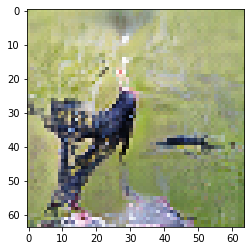

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 29

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.38780164718628 sec
Gen loss: 1.5307436118604045, Disc loss: 1.0058313002431296, Disc real loss: 0.5126589844381906, Disc fake loss: 0.49317231588570404
Time for epoch 2 is 13.388609886169434 sec
Gen loss: 1.520304335165153, Disc loss: 1.0111568562060513, Disc real loss: 0.5142110355178192, Disc fake loss: 0.4969458185075744
Time for epoch 3 is 13.272096872329712 sec
Gen loss: 1.5313959467378735, Disc loss: 1.008673179440382, Disc real loss: 0.511615966716756, Disc fake loss: 0.4970572093314918
Time for epoch 4 is 13.457220792770386 sec
Gen loss: 1.5198556200921698, Disc loss: 1.0098327937811047, Disc real loss: 0.5142620868960693, Disc fake loss: 0.49557070793498176
Time for epoch 5 is 13.382843255996704 sec
Gen loss: 1.5149588688279232, Disc loss: 1.0050750358640985, Disc real loss: 0.5079268539339546, Disc fake loss: 0.4971481817686138
Time for e

Time for epoch 48 is 13.305125951766968 sec
Gen loss: 1.530997403591952, Disc loss: 1.0075321029518356, Disc real loss: 0.5100821328518513, Disc fake loss: 0.4974499730075278
Time for epoch 49 is 13.458969116210938 sec
Gen loss: 1.5235849366924628, Disc loss: 1.0104563950200067, Disc real loss: 0.512622684805697, Disc fake loss: 0.497833711102726
Time for epoch 50 is 13.368765592575073 sec
Gen loss: 1.5074048833795357, Disc loss: 1.0089121028013668, Disc real loss: 0.5109211014215216, Disc fake loss: 0.49799100146061037
Time for epoch 51 is 13.300532102584839 sec
Gen loss: 1.5202567732431056, Disc loss: 1.0132562017376183, Disc real loss: 0.5154359704918332, Disc fake loss: 0.49782023100348993
Time for epoch 52 is 13.322971820831299 sec
Gen loss: 1.519131611356244, Disc loss: 1.0121280198820883, Disc real loss: 0.5136768029634222, Disc fake loss: 0.49845121829167294
Time for epoch 53 is 13.519983053207397 sec
Gen loss: 1.5209617462907703, Disc loss: 1.013083704764927, Disc real loss: 0

Time for epoch 95 is 13.327370643615723 sec
Gen loss: 1.5224102334924507, Disc loss: 1.0041515064756399, Disc real loss: 0.508680576635247, Disc fake loss: 0.49547092903274187
Time for epoch 96 is 13.476124286651611 sec
Gen loss: 1.513200223930483, Disc loss: 1.0103938154734893, Disc real loss: 0.512867837821242, Disc fake loss: 0.49752597894448897
Time for epoch 97 is 13.375578880310059 sec
Gen loss: 1.5313001932490486, Disc loss: 1.009472979116569, Disc real loss: 0.5081220572072316, Disc fake loss: 0.5013509201325053
Time for epoch 98 is 13.362642765045166 sec
Gen loss: 1.5163815415648587, Disc loss: 1.0105927263495076, Disc real loss: 0.5137734356611402, Disc fake loss: 0.4968192913344882
Time for epoch 99 is 13.297874689102173 sec
Gen loss: 1.521056374883264, Disc loss: 1.0134157948700717, Disc real loss: 0.513744466753833, Disc fake loss: 0.4996713289238896
Time for epoch 100 is 13.38417935371399 sec
Gen loss: 1.52002621117, Disc loss: 1.0095192791646734, Disc real loss: 0.514279

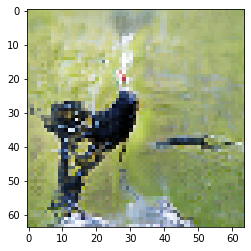

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 30

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.384116649627686 sec
Gen loss: 1.5199563732638268, Disc loss: 1.0078233611292955, Disc real loss: 0.5101008203617603, Disc fake loss: 0.4977225407675353
Time for epoch 2 is 13.33260202407837 sec
Gen loss: 1.5183186844435488, Disc loss: 1.0124754674712493, Disc real loss: 0.5115313658384772, Disc fake loss: 0.5009441008251211
Time for epoch 3 is 13.42093825340271 sec
Gen loss: 1.5285454187289809, Disc loss: 1.0117334143579169, Disc real loss: 0.5136378456745044, Disc fake loss: 0.49809556916800296
Time for epoch 4 is 13.363426685333252 sec
Gen loss: 1.509680075374076, Disc loss: 1.0181045399771795, Disc real loss: 0.5179476036934995, Disc fake loss: 0.5001569366067405
Time for epoch 5 is 13.374783515930176 sec
Gen loss: 1.53841191804829, Disc loss: 1.0043770326831476, Disc real loss: 0.5075330958779911, Disc fake loss: 0.4968439377743377
Time for epo

Time for epoch 48 is 13.389230966567993 sec
Gen loss: 1.512598887045532, Disc loss: 1.016471509041825, Disc real loss: 0.5191196674900003, Disc fake loss: 0.497351841067234
Time for epoch 49 is 13.28007960319519 sec
Gen loss: 1.5409626844452649, Disc loss: 1.0043037777670676, Disc real loss: 0.50810516106727, Disc fake loss: 0.4961986183958648
Time for epoch 50 is 13.486828804016113 sec
Gen loss: 1.5157708084680201, Disc loss: 1.0089122292795156, Disc real loss: 0.5132564874037817, Disc fake loss: 0.49565574050272704
Time for epoch 51 is 13.33206820487976 sec
Gen loss: 1.5272092977513465, Disc loss: 1.0100721461663078, Disc real loss: 0.5129985777020132, Disc fake loss: 0.4970735691911806
Time for epoch 52 is 13.441907167434692 sec
Gen loss: 1.5279527640924222, Disc loss: 1.0073610524821088, Disc real loss: 0.5090513419168106, Disc fake loss: 0.4983097091115264
Time for epoch 53 is 13.385928392410278 sec
Gen loss: 1.514546959057733, Disc loss: 1.0111649716449624, Disc real loss: 0.5117

Time for epoch 95 is 13.37688660621643 sec
Gen loss: 1.49970575270614, Disc loss: 1.0118382636124525, Disc real loss: 0.5153172537886354, Disc fake loss: 0.496521008046985
Time for epoch 96 is 13.372710704803467 sec
Gen loss: 1.509559258859009, Disc loss: 1.016449295085297, Disc real loss: 0.514779627646211, Disc fake loss: 0.501669665823784
Time for epoch 97 is 13.402514934539795 sec
Gen loss: 1.5537230341738155, Disc loss: 1.0042816933577623, Disc real loss: 0.5071435520642495, Disc fake loss: 0.49713814016280133
Time for epoch 98 is 13.374434471130371 sec
Gen loss: 1.5060101185387713, Disc loss: 1.0173078683333667, Disc real loss: 0.5204547348061228, Disc fake loss: 0.49685313595019703
Time for epoch 99 is 13.364251375198364 sec
Gen loss: 1.5094879319674277, Disc loss: 1.0111079067395632, Disc real loss: 0.5163495140023994, Disc fake loss: 0.4947583928179289
Time for epoch 100 is 13.374898672103882 sec
Gen loss: 1.5126475874324479, Disc loss: 1.0096637630850318, Disc real loss: 0.51

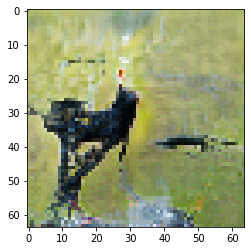

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 31

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.363917827606201 sec
Gen loss: 1.505611347635264, Disc loss: 1.019946734756635, Disc real loss: 0.5203560310489117, Disc fake loss: 0.49959070330389793
Time for epoch 2 is 13.369714975357056 sec
Gen loss: 1.520830944947757, Disc loss: 1.0132811636459538, Disc real loss: 0.5124981689259289, Disc fake loss: 0.5007829942354342
Time for epoch 3 is 13.376396417617798 sec
Gen loss: 1.518558397202634, Disc loss: 1.0073961830397609, Disc real loss: 0.5143456881446891, Disc fake loss: 0.4930504949758369
Time for epoch 4 is 13.398630619049072 sec
Gen loss: 1.5187618318935074, Disc loss: 1.015843005684333, Disc real loss: 0.5180323968734845, Disc fake loss: 0.4978106125260433
Time for epoch 5 is 13.365469455718994 sec
Gen loss: 1.518074870109558, Disc loss: 1.0032111995911535, Disc real loss: 0.5074498033135887, Disc fake loss: 0.49576139668139013
Time for epo

Time for epoch 48 is 13.473554372787476 sec
Gen loss: 1.5031964895201892, Disc loss: 1.0150009854053095, Disc real loss: 0.5128891676422057, Disc fake loss: 0.5021118157439761
Time for epoch 49 is 13.39687442779541 sec
Gen loss: 1.5179787454243274, Disc loss: 1.013483659200229, Disc real loss: 0.5133704644070085, Disc fake loss: 0.5001131951162808
Time for epoch 50 is 13.2761709690094 sec
Gen loss: 1.5137359236637105, Disc loss: 1.0050364328916803, Disc real loss: 0.5116881052976056, Disc fake loss: 0.49334832694795394
Time for epoch 51 is 13.399877548217773 sec
Gen loss: 1.5152362714291912, Disc loss: 1.0152456684487299, Disc real loss: 0.5137969269985105, Disc fake loss: 0.5014487384619105
Time for epoch 52 is 13.346775531768799 sec
Gen loss: 1.5130790358959498, Disc loss: 1.0156283349525639, Disc real loss: 0.5178751060310095, Disc fake loss: 0.49775322706395697
Time for epoch 53 is 13.439071416854858 sec
Gen loss: 1.547793291771638, Disc loss: 1.0101490599030079, Disc real loss: 0.

Time for epoch 95 is 13.338643789291382 sec
Gen loss: 1.5307843452546654, Disc loss: 1.0048058711416352, Disc real loss: 0.5094341428945381, Disc fake loss: 0.4953717283278623
Time for epoch 96 is 13.393197536468506 sec
Gen loss: 1.5058738464908548, Disc loss: 1.0179884902183927, Disc real loss: 0.5170620353564337, Disc fake loss: 0.5009264522774756
Time for epoch 97 is 13.34280252456665 sec
Gen loss: 1.5082372372066426, Disc loss: 1.0154111836014725, Disc real loss: 0.519380351230704, Disc fake loss: 0.4960308332591845
Time for epoch 98 is 13.338316917419434 sec
Gen loss: 1.5191404845333358, Disc loss: 1.0125450522595951, Disc real loss: 0.5133232297451515, Disc fake loss: 0.4992218227567388
Time for epoch 99 is 13.480318546295166 sec
Gen loss: 1.5190513185692351, Disc loss: 1.0127815828736881, Disc real loss: 0.5171312672012867, Disc fake loss: 0.49565031510704577
Time for epoch 100 is 13.45239520072937 sec
Gen loss: 1.5124932973365472, Disc loss: 1.0055738588981835, Disc real loss: 

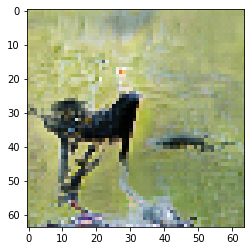

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 32

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.38867974281311 sec
Gen loss: 1.521588781984841, Disc loss: 1.0101319284943062, Disc real loss: 0.5137124764240855, Disc fake loss: 0.4964194532009321
Time for epoch 2 is 13.319212675094604 sec
Gen loss: 1.535375762115003, Disc loss: 1.0161043890123445, Disc real loss: 0.514377190976285, Disc fake loss: 0.5017271998936568
Time for epoch 3 is 13.327167749404907 sec
Gen loss: 1.5163322842218043, Disc loss: 1.009800428620522, Disc real loss: 0.5144662248894452, Disc fake loss: 0.49533420502331843
Time for epoch 4 is 13.31052041053772 sec
Gen loss: 1.5161374707209063, Disc loss: 1.01544795255997, Disc real loss: 0.5153793173269204, Disc fake loss: 0.5000686353138146
Time for epoch 5 is 13.488567352294922 sec
Gen loss: 1.5188385742466624, Disc loss: 1.002997196786772, Disc real loss: 0.5097883869477404, Disc fake loss: 0.49320880967750136
Time for epoch 

Time for epoch 48 is 13.271579504013062 sec
Gen loss: 1.5241209352565652, Disc loss: 1.0132132620023195, Disc real loss: 0.5111805024508861, Disc fake loss: 0.5020327606013797
Time for epoch 49 is 13.355135679244995 sec
Gen loss: 1.5188119463158172, Disc loss: 1.0095000732235793, Disc real loss: 0.5144829541687074, Disc fake loss: 0.4950171176011
Time for epoch 50 is 13.427878618240356 sec
Gen loss: 1.5268133087209892, Disc loss: 1.0017299537413165, Disc real loss: 0.5104436298534476, Disc fake loss: 0.49128632461475485
Time for epoch 51 is 13.327701568603516 sec
Gen loss: 1.5546559799654374, Disc loss: 1.0025259367818755, Disc real loss: 0.51015702875326, Disc fake loss: 0.4923689072209645
Time for epoch 52 is 13.40361499786377 sec
Gen loss: 1.5060628788258001, Disc loss: 1.015139039131361, Disc real loss: 0.5179572569807047, Disc fake loss: 0.4971817799699985
Time for epoch 53 is 13.310274600982666 sec
Gen loss: 1.5244323677486844, Disc loss: 1.0081873854324424, Disc real loss: 0.515

Time for epoch 95 is 13.323134899139404 sec
Gen loss: 1.536259334584885, Disc loss: 1.0103389948687256, Disc real loss: 0.5139329761347473, Disc fake loss: 0.4964060198646897
Time for epoch 96 is 13.455512762069702 sec
Gen loss: 1.5254592443223245, Disc loss: 1.0050437519866922, Disc real loss: 0.5102430963257787, Disc fake loss: 0.49480065574167864
Time for epoch 97 is 13.33381199836731 sec
Gen loss: 1.5388627688736127, Disc loss: 1.0060768295432816, Disc real loss: 0.510606215494435, Disc fake loss: 0.49547061614873933
Time for epoch 98 is 13.425912857055664 sec
Gen loss: 1.5334437361900723, Disc loss: 1.0111399512626937, Disc real loss: 0.5162473441301, Disc fake loss: 0.49489260640570787
Time for epoch 99 is 13.409312725067139 sec
Gen loss: 1.5272877054808909, Disc loss: 1.004894068570641, Disc real loss: 0.5113802019173537, Disc fake loss: 0.4935138660071665
Time for epoch 100 is 13.380417823791504 sec
Gen loss: 1.5155785865576932, Disc loss: 1.0069396219602444, Disc real loss: 0.

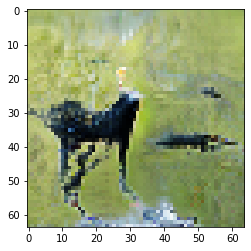

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 33

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.280951499938965 sec
Gen loss: 1.5203124953479301, Disc loss: 1.0113868177098633, Disc real loss: 0.5188906960048003, Disc fake loss: 0.4924961231588348
Time for epoch 2 is 13.368918657302856 sec
Gen loss: 1.538005243148907, Disc loss: 1.0131459893572945, Disc real loss: 0.5159519385031568, Disc fake loss: 0.49719405456933224
Time for epoch 3 is 13.356860160827637 sec
Gen loss: 1.5062169657167057, Disc loss: 1.0168002113740295, Disc real loss: 0.5138314829932319, Disc fake loss: 0.502968727815442
Time for epoch 4 is 13.40058946609497 sec
Gen loss: 1.516568541203734, Disc loss: 1.0128803645692221, Disc real loss: 0.5183120671165021, Disc fake loss: 0.49456829834113597
Time for epoch 5 is 13.344728946685791 sec
Gen loss: 1.5203261126670733, Disc loss: 1.0063398338268765, Disc real loss: 0.5118224044963919, Disc fake loss: 0.49451742908818935
Time for 

Time for epoch 48 is 13.480295419692993 sec
Gen loss: 1.5033118705439374, Disc loss: 1.0215557665036623, Disc real loss: 0.5219171838708686, Disc fake loss: 0.4996385811790218
Time for epoch 49 is 13.411826610565186 sec
Gen loss: 1.5599412003829873, Disc loss: 1.0052625307545753, Disc real loss: 0.5095686322143731, Disc fake loss: 0.4956939002362693
Time for epoch 50 is 13.315069437026978 sec
Gen loss: 1.5247131850984361, Disc loss: 0.9982532143269774, Disc real loss: 0.5075410688472634, Disc fake loss: 0.49071214232987503
Time for epoch 51 is 13.304652690887451 sec
Gen loss: 1.5152521398332384, Disc loss: 1.0160300505516653, Disc real loss: 0.5157012256180368, Disc fake loss: 0.5003288246913331
Time for epoch 52 is 13.392976522445679 sec
Gen loss: 1.527251923956522, Disc loss: 1.0103016187181963, Disc real loss: 0.5150371049316271, Disc fake loss: 0.4952645133827437
Time for epoch 53 is 13.392926454544067 sec
Gen loss: 1.5083740846251408, Disc loss: 1.0199563159206049, Disc real loss:

Time for epoch 95 is 13.31454610824585 sec
Gen loss: 1.5160111815625736, Disc loss: 1.0069348629574142, Disc real loss: 0.5114106983350222, Disc fake loss: 0.4955241644608619
Time for epoch 96 is 13.323564052581787 sec
Gen loss: 1.5221177526928868, Disc loss: 1.0076429554763524, Disc real loss: 0.5119057004529286, Disc fake loss: 0.49573725276200103
Time for epoch 97 is 13.299639701843262 sec
Gen loss: 1.5304223987145154, Disc loss: 1.010548107346222, Disc real loss: 0.5154340617701936, Disc fake loss: 0.4951140422646592
Time for epoch 98 is 13.313773393630981 sec
Gen loss: 1.5035478412943482, Disc loss: 1.0179585483339098, Disc real loss: 0.518044205781244, Disc fake loss: 0.49991434166424964
Time for epoch 99 is 13.316761016845703 sec
Gen loss: 1.5353024894306007, Disc loss: 1.0074261581994655, Disc real loss: 0.514115825416596, Disc fake loss: 0.4933103322175137
Time for epoch 100 is 13.314814805984497 sec
Gen loss: 1.5284636718470876, Disc loss: 1.0008421514415482, Disc real loss: 

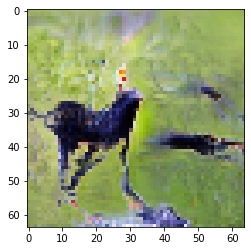

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 34

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.3545241355896 sec
Gen loss: 1.5267703966073551, Disc loss: 1.0108581054501418, Disc real loss: 0.5151945059377003, Disc fake loss: 0.49566359822019973
Time for epoch 2 is 13.530058145523071 sec
Gen loss: 1.5149291747307714, Disc loss: 1.0148610280458197, Disc real loss: 0.5141820451269951, Disc fake loss: 0.5006789815458179
Time for epoch 3 is 13.356772899627686 sec
Gen loss: 1.535786395473532, Disc loss: 1.0066388496538488, Disc real loss: 0.5120416328028289, Disc fake loss: 0.4945972175779058
Time for epoch 4 is 13.33255934715271 sec
Gen loss: 1.5240229613735747, Disc loss: 1.014507077735291, Disc real loss: 0.5172622114177642, Disc fake loss: 0.4972448681751241
Time for epoch 5 is 13.386101245880127 sec
Gen loss: 1.5174149371744172, Disc loss: 1.0033913304812216, Disc real loss: 0.5075003347261166, Disc fake loss: 0.49589099502821926
Time for ep

Time for epoch 48 is 13.436948537826538 sec
Gen loss: 1.5253634969716472, Disc loss: 1.0130887734211558, Disc real loss: 0.5164083827155715, Disc fake loss: 0.4966803904632889
Time for epoch 49 is 13.295670986175537 sec
Gen loss: 1.5329354213182196, Disc loss: 1.0062062827552236, Disc real loss: 0.5104394821616692, Disc fake loss: 0.4957668003512592
Time for epoch 50 is 13.34499478340149 sec
Gen loss: 1.5232235328937933, Disc loss: 1.0008099061363758, Disc real loss: 0.5079144277385257, Disc fake loss: 0.4928954740365346
Time for epoch 51 is 13.440127849578857 sec
Gen loss: 1.509531182971427, Disc loss: 1.0169990632915238, Disc real loss: 0.5140169326690477, Disc fake loss: 0.5029821314301272
Time for epoch 52 is 13.431937456130981 sec
Gen loss: 1.5269731880849615, Disc loss: 1.0100571356491668, Disc real loss: 0.5124839634753178, Disc fake loss: 0.49757317225461406
Time for epoch 53 is 13.303170919418335 sec
Gen loss: 1.5203765495036676, Disc loss: 1.0139919333664706, Disc real loss: 

Time for epoch 95 is 13.405802488327026 sec
Gen loss: 1.5132264625735399, Disc loss: 1.0086543354884718, Disc real loss: 0.5096571433350323, Disc fake loss: 0.49899719078043286
Time for epoch 96 is 13.416190147399902 sec
Gen loss: 1.5210741037921853, Disc loss: 1.0099267051794987, Disc real loss: 0.5147649355858646, Disc fake loss: 0.4951617690282785
Time for epoch 97 is 13.289160966873169 sec
Gen loss: 1.5274613417261016, Disc loss: 1.0118855963231426, Disc real loss: 0.5135468216284826, Disc fake loss: 0.49833877493695516
Time for epoch 98 is 13.36101770401001 sec
Gen loss: 1.523165255381163, Disc loss: 1.0127785690431672, Disc real loss: 0.5163003414627013, Disc fake loss: 0.496478226045929
Time for epoch 99 is 13.367848873138428 sec
Gen loss: 1.5186301246891176, Disc loss: 1.015471817516699, Disc real loss: 0.5195185478302199, Disc fake loss: 0.4959532672635262
Time for epoch 100 is 13.361535549163818 sec
Gen loss: 1.520148619403684, Disc loss: 1.007242736777639, Disc real loss: 0.

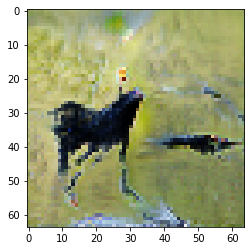

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 35

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.401199102401733 sec
Gen loss: 1.5167928985786956, Disc loss: 1.0127359803129987, Disc real loss: 0.5157659977755249, Disc fake loss: 0.4969699843950711
Time for epoch 2 is 13.370453596115112 sec
Gen loss: 1.5195755047526787, Disc loss: 1.011733645669167, Disc real loss: 0.5126204714380952, Disc fake loss: 0.49911317447336706
Time for epoch 3 is 13.370729446411133 sec
Gen loss: 1.5215782224324337, Disc loss: 1.0153454816761378, Disc real loss: 0.5192782611543247, Disc fake loss: 0.49606721898727624
Time for epoch 4 is 13.38020658493042 sec
Gen loss: 1.5459495937921168, Disc loss: 1.0079736095779956, Disc real loss: 0.5104224998453445, Disc fake loss: 0.4975511100557115
Time for epoch 5 is 13.355257987976074 sec
Gen loss: 1.5156235019689006, Disc loss: 1.0086638751391797, Disc real loss: 0.509266739776787, Disc fake loss: 0.4993971364931039
Time for 

Time for epoch 48 is 13.350256204605103 sec
Gen loss: 1.5239945598411042, Disc loss: 1.008554569266353, Disc real loss: 0.5162395473902788, Disc fake loss: 0.4923150229260204
Time for epoch 49 is 13.364498376846313 sec
Gen loss: 1.532098276182242, Disc loss: 1.0066178667189951, Disc real loss: 0.5109979633070266, Disc fake loss: 0.4956199023620223
Time for epoch 50 is 13.393302202224731 sec
Gen loss: 1.5344168946025818, Disc loss: 1.0039746758091417, Disc real loss: 0.5105557940839752, Disc fake loss: 0.49341888237128734
Time for epoch 51 is 13.475691795349121 sec
Gen loss: 1.5162451415850218, Disc loss: 1.0171986210960036, Disc real loss: 0.5175496544941331, Disc fake loss: 0.4996489647442732
Time for epoch 52 is 13.286309003829956 sec
Gen loss: 1.5180158553730827, Disc loss: 1.012893900315613, Disc real loss: 0.5143550684458518, Disc fake loss: 0.4985388321928216
Time for epoch 53 is 13.42531442642212 sec
Gen loss: 1.5252641949873307, Disc loss: 1.011781565057553, Disc real loss: 0.5

Time for epoch 95 is 13.333964824676514 sec
Gen loss: 1.5188594019509913, Disc loss: 1.009516425087523, Disc real loss: 0.5118058984518697, Disc fake loss: 0.4977105286547808
Time for epoch 96 is 13.332084655761719 sec
Gen loss: 1.521550724499917, Disc loss: 1.0156366653881745, Disc real loss: 0.51519518719133, Disc fake loss: 0.5004414788429653
Time for epoch 97 is 13.32408857345581 sec
Gen loss: 1.510747662081628, Disc loss: 1.0150941025596971, Disc real loss: 0.5158630114422258, Disc fake loss: 0.49923109176359204
Time for epoch 98 is 13.514224529266357 sec
Gen loss: 1.5242423914312346, Disc loss: 1.0113179547999933, Disc real loss: 0.5181189853809067, Disc fake loss: 0.493198969015261
Time for epoch 99 is 13.392096519470215 sec
Gen loss: 1.5111368487520915, Disc loss: 1.0177336648550783, Disc real loss: 0.5190027887582133, Disc fake loss: 0.49873087327008647
Time for epoch 100 is 13.408914566040039 sec
Gen loss: 1.51010164917323, Disc loss: 1.0126584616456897, Disc real loss: 0.514

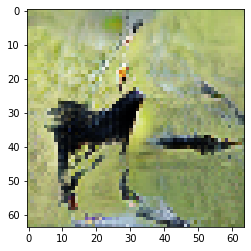

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 36

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.398711204528809 sec
Gen loss: 1.5099327225026076, Disc loss: 1.0153461702793918, Disc real loss: 0.5157046658075276, Disc fake loss: 0.499641501968146
Time for epoch 2 is 13.370535850524902 sec
Gen loss: 1.5162061446404393, Disc loss: 1.0142977604374976, Disc real loss: 0.5142069616453434, Disc fake loss: 0.5000907980652682
Time for epoch 3 is 13.385993003845215 sec
Gen loss: 1.5219682106157628, Disc loss: 1.013106658529783, Disc real loss: 0.5149270768572645, Disc fake loss: 0.49817958159175346
Time for epoch 4 is 13.442582845687866 sec
Gen loss: 1.5267412672197915, Disc loss: 1.0113661747960863, Disc real loss: 0.5169420771320984, Disc fake loss: 0.49442409927929
Time for epoch 5 is 13.308333158493042 sec
Gen loss: 1.5257096927017377, Disc loss: 1.0042945753914232, Disc real loss: 0.5129686349291143, Disc fake loss: 0.4913259388470068
Time for ep

Time for epoch 48 is 13.387040138244629 sec
Gen loss: 1.5225328959746736, Disc loss: 1.0126820247024702, Disc real loss: 0.5148171378668085, Disc fake loss: 0.49786488570495024
Time for epoch 49 is 13.382084608078003 sec
Gen loss: 1.5238240750501473, Disc loss: 1.0095997911481676, Disc real loss: 0.511586093159549, Disc fake loss: 0.49801369823091396
Time for epoch 50 is 13.381891250610352 sec
Gen loss: 1.522124512408807, Disc loss: 1.0082479655581116, Disc real loss: 0.5131824971214543, Disc fake loss: 0.49506546698288545
Time for epoch 51 is 13.379472494125366 sec
Gen loss: 1.5170123260518722, Disc loss: 1.0153209684987055, Disc real loss: 0.5149238038515334, Disc fake loss: 0.5003971619011587
Time for epoch 52 is 13.36972975730896 sec
Gen loss: 1.5403055362908176, Disc loss: 1.0082271150780242, Disc real loss: 0.5105086598131392, Disc fake loss: 0.4977184531649923
Time for epoch 53 is 13.401594161987305 sec
Gen loss: 1.5074260260677597, Disc loss: 1.0187285002977222, Disc real loss:

Time for epoch 95 is 13.360791683197021 sec
Gen loss: 1.5459056359319505, Disc loss: 1.0012317488833171, Disc real loss: 0.5078416210687581, Disc fake loss: 0.49339012886450545
Time for epoch 96 is 13.384784698486328 sec
Gen loss: 1.5130806217994794, Disc loss: 1.014147623929228, Disc real loss: 0.5172635072130498, Disc fake loss: 0.4968841159085271
Time for epoch 97 is 13.367127180099487 sec
Gen loss: 1.5090322281286968, Disc loss: 1.0156853565678687, Disc real loss: 0.5154935351716794, Disc fake loss: 0.5001918201039477
Time for epoch 98 is 13.413782596588135 sec
Gen loss: 1.5232583397449193, Disc loss: 1.0129349687235143, Disc real loss: 0.5157370554399361, Disc fake loss: 0.497197913202813
Time for epoch 99 is 13.361225128173828 sec
Gen loss: 1.5228029789963389, Disc loss: 1.0095591588718136, Disc real loss: 0.5148383828844159, Disc fake loss: 0.4947207766335185
Time for epoch 100 is 13.361847639083862 sec
Gen loss: 1.53223506771129, Disc loss: 1.0061442805176506, Disc real loss: 0

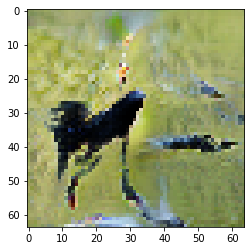

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 37

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.365661382675171 sec
Gen loss: 1.5137359837529458, Disc loss: 1.020549824567345, Disc real loss: 0.5210117956164083, Disc fake loss: 0.49953802927399715
Time for epoch 2 is 13.387526273727417 sec
Gen loss: 1.517698229489934, Disc loss: 1.0189010053469236, Disc real loss: 0.5165142488834981, Disc fake loss: 0.5023867586440833
Time for epoch 3 is 13.398218393325806 sec
Gen loss: 1.518033965170222, Disc loss: 1.0158512183644262, Disc real loss: 0.5118949599059294, Disc fake loss: 0.5039562580546713
Time for epoch 4 is 13.364766120910645 sec
Gen loss: 1.5107525606465533, Disc loss: 1.0140150239474082, Disc real loss: 0.5151243404482762, Disc fake loss: 0.4988906808338837
Time for epoch 5 is 13.37793755531311 sec
Gen loss: 1.5193426263364673, Disc loss: 1.0126870051632082, Disc real loss: 0.5150375394478723, Disc fake loss: 0.4976494680575239
Time for ep

Time for epoch 48 is 13.449082612991333 sec
Gen loss: 1.5214033223749177, Disc loss: 1.0143033419521197, Disc real loss: 0.5134178976702496, Disc fake loss: 0.5008854450895212
Time for epoch 49 is 13.349952220916748 sec
Gen loss: 1.5026133774418817, Disc loss: 1.0235719801933785, Disc real loss: 0.5223808459796233, Disc fake loss: 0.5011911327599833
Time for epoch 50 is 13.43634033203125 sec
Gen loss: 1.5043276238247631, Disc loss: 1.0133680791712711, Disc real loss: 0.517831391839154, Disc fake loss: 0.49553668927047956
Time for epoch 51 is 13.267919778823853 sec
Gen loss: 1.5170563527239047, Disc loss: 1.0146890804373474, Disc real loss: 0.5171035422380701, Disc fake loss: 0.4975855365032103
Time for epoch 52 is 13.458243608474731 sec
Gen loss: 1.5319588992007702, Disc loss: 1.0073149002341397, Disc real loss: 0.5100431149891076, Disc fake loss: 0.4972717860526832
Time for epoch 53 is 13.424260139465332 sec
Gen loss: 1.5197382932756005, Disc loss: 1.0122291784945543, Disc real loss: 

Time for epoch 95 is 13.429680347442627 sec
Gen loss: 1.5250959115299751, Disc loss: 1.0064003800312031, Disc real loss: 0.5102067553415531, Disc fake loss: 0.4961936210552205
Time for epoch 96 is 13.355355024337769 sec
Gen loss: 1.5214709644395161, Disc loss: 1.0125326336560856, Disc real loss: 0.5158778290923048, Disc fake loss: 0.49665480391766
Time for epoch 97 is 13.404820203781128 sec
Gen loss: 1.524801646467793, Disc loss: 1.0076890875330462, Disc real loss: 0.5109292025650097, Disc fake loss: 0.4967598822220231
Time for epoch 98 is 13.364884853363037 sec
Gen loss: 1.5198846532077324, Disc loss: 1.015017710080961, Disc real loss: 0.5154963193062522, Disc fake loss: 0.49952139134006446
Time for epoch 99 is 13.357335805892944 sec
Gen loss: 1.50771352204527, Disc loss: 1.0178091661716864, Disc real loss: 0.5206290464091107, Disc fake loss: 0.4971801198433408
Time for epoch 100 is 13.344804048538208 sec
Gen loss: 1.517403944074946, Disc loss: 1.008052452631436, Disc real loss: 0.513

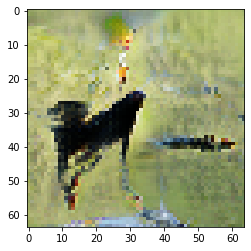

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 38

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.352937698364258 sec
Gen loss: 1.549854959252727, Disc loss: 1.0031490235470821, Disc real loss: 0.5089231215841402, Disc fake loss: 0.4942259011552909
Time for epoch 2 is 13.363161325454712 sec
Gen loss: 1.5110180785016316, Disc loss: 1.0140476908464096, Disc real loss: 0.5147942731858592, Disc fake loss: 0.499253418952792
Time for epoch 3 is 13.36294436454773 sec
Gen loss: 1.524530818468833, Disc loss: 1.0078388966195952, Disc real loss: 0.5129805884064051, Disc fake loss: 0.4948583062748276
Time for epoch 4 is 13.35830569267273 sec
Gen loss: 1.5288773112826877, Disc loss: 1.0094817429377134, Disc real loss: 0.5126449249301176, Disc fake loss: 0.49683681776530053
Time for epoch 5 is 13.353925943374634 sec
Gen loss: 1.525531523919041, Disc loss: 1.0079707671310196, Disc real loss: 0.5081854049913929, Disc fake loss: 0.4997853624626873
Time for epoc

Time for epoch 48 is 13.377870798110962 sec
Gen loss: 1.5218378825562433, Disc loss: 1.0129950729812063, Disc real loss: 0.5175677293199834, Disc fake loss: 0.4954273442265787
Time for epoch 49 is 13.377881050109863 sec
Gen loss: 1.5301161161283168, Disc loss: 1.00870377116087, Disc real loss: 0.5147789673915077, Disc fake loss: 0.4939248031232415
Time for epoch 50 is 13.37141466140747 sec
Gen loss: 1.514105869502556, Disc loss: 1.0121791165695604, Disc real loss: 0.5173496788917842, Disc fake loss: 0.4948294369508904
Time for epoch 51 is 13.408835887908936 sec
Gen loss: 1.519234792326847, Disc loss: 1.0096136948603602, Disc real loss: 0.5102238907885099, Disc fake loss: 0.49938980407185024
Time for epoch 52 is 13.36426854133606 sec
Gen loss: 1.5224503275501695, Disc loss: 1.0104786501667364, Disc real loss: 0.514152398681253, Disc fake loss: 0.49632625326231566
Time for epoch 53 is 13.371055364608765 sec
Gen loss: 1.5357077286495426, Disc loss: 1.0119350000125606, Disc real loss: 0.51

Time for epoch 95 is 13.275846004486084 sec
Gen loss: 1.52589115799281, Disc loss: 1.0105046604060868, Disc real loss: 0.5107727346381521, Disc fake loss: 0.49973192601023003
Time for epoch 96 is 13.452898740768433 sec
Gen loss: 1.5191469848317505, Disc loss: 1.0139268081039594, Disc real loss: 0.5162190291778181, Disc fake loss: 0.49770777626089285
Time for epoch 97 is 13.498637676239014 sec
Gen loss: 1.522759235002161, Disc loss: 1.0114649645681304, Disc real loss: 0.514296736497543, Disc fake loss: 0.497168227828292
Time for epoch 98 is 13.403254985809326 sec
Gen loss: 1.522711420123816, Disc loss: 1.010244811938061, Disc real loss: 0.5144850047138648, Disc fake loss: 0.49575980722419616
Time for epoch 99 is 13.3456871509552 sec
Gen loss: 1.5165316228297991, Disc loss: 1.018580079724795, Disc real loss: 0.517468805316341, Disc fake loss: 0.5011112748122797
Time for epoch 100 is 13.496497631072998 sec
Gen loss: 1.525150655730953, Disc loss: 1.0034344469305623, Disc real loss: 0.50753

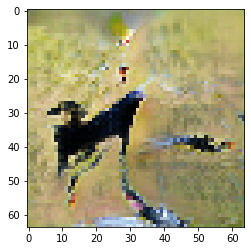

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 39

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.420251369476318 sec
Gen loss: 1.535815081299159, Disc loss: 1.0119293141494274, Disc real loss: 0.5115371187366444, Disc fake loss: 0.5003921948474274
Time for epoch 2 is 13.350342512130737 sec
Gen loss: 1.513815319958095, Disc loss: 1.015569774277488, Disc real loss: 0.5170588785716834, Disc fake loss: 0.4985108945750932
Time for epoch 3 is 13.433339834213257 sec
Gen loss: 1.5248852302711509, Disc loss: 1.0077059133266046, Disc real loss: 0.511022161662094, Disc fake loss: 0.49668375384516833
Time for epoch 4 is 13.453445196151733 sec
Gen loss: 1.5235881440361665, Disc loss: 1.0163428066222648, Disc real loss: 0.5145632039079175, Disc fake loss: 0.5017796042488842
Time for epoch 5 is 13.33884048461914 sec
Gen loss: 1.524333387209471, Disc loss: 1.0048738650190152, Disc real loss: 0.5084415322073753, Disc fake loss: 0.49643233483076743
Time for epo

Time for epoch 48 is 13.392746925354004 sec
Gen loss: 1.5545508732317586, Disc loss: 1.0081902408018344, Disc real loss: 0.5076075741430608, Disc fake loss: 0.5005826669818341
Time for epoch 49 is 13.451379537582397 sec
Gen loss: 1.5101172688207651, Disc loss: 1.0172889768915772, Disc real loss: 0.5213472305274591, Disc fake loss: 0.4959417483024804
Time for epoch 50 is 13.410810947418213 sec
Gen loss: 1.5217214790463125, Disc loss: 1.0052724718078365, Disc real loss: 0.5107948461845315, Disc fake loss: 0.49447762820778823
Time for epoch 51 is 13.403188228607178 sec
Gen loss: 1.524758941758939, Disc loss: 1.0099983000496862, Disc real loss: 0.5115487781482014, Disc fake loss: 0.49844952230531026
Time for epoch 52 is 13.499209880828857 sec
Gen loss: 1.5198713140435982, Disc loss: 1.0157224926845168, Disc real loss: 0.5148407908959117, Disc fake loss: 0.50088170170784
Time for epoch 53 is 13.536648750305176 sec
Gen loss: 1.5184760956260246, Disc loss: 1.0126900968512869, Disc real loss: 

Time for epoch 95 is 13.3800048828125 sec
Gen loss: 1.5276046099701548, Disc loss: 1.0055951309720998, Disc real loss: 0.510612835567495, Disc fake loss: 0.4949822969391417
Time for epoch 96 is 13.394349098205566 sec
Gen loss: 1.5104617326240228, Disc loss: 1.0213243615659595, Disc real loss: 0.5172457823423835, Disc fake loss: 0.504078580111992
Time for epoch 97 is 13.396058559417725 sec
Gen loss: 1.5231059434291148, Disc loss: 1.0149754875397619, Disc real loss: 0.5140776479954965, Disc fake loss: 0.500897836152131
Time for epoch 98 is 13.380891799926758 sec
Gen loss: 1.5195710071057162, Disc loss: 1.0174523239859397, Disc real loss: 0.5193071920212692, Disc fake loss: 0.4981451318839055
Time for epoch 99 is 13.386606693267822 sec
Gen loss: 1.5187940939978208, Disc loss: 1.0123172869204182, Disc real loss: 0.5177417176202707, Disc fake loss: 0.4945755677656106
Time for epoch 100 is 13.391041994094849 sec
Gen loss: 1.5223655416390438, Disc loss: 1.0059548605102187, Disc real loss: 0.5

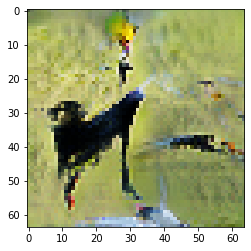

In [19]:
next_starting_checkpoint = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=30, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      d_hist=disc_loss_hist,
                                      d_real_hist=disc_loss_real_hist,
                                      d_fake_hist=disc_loss_fake_hist,
                                      noise=noise100,
                                      save_files=True)

In [ ]:
# noise = np.random.normal(0, 1, 200)

# gen_loss_hist = []
# disc_loss_hist = []

# for i in range(30, 40):
#     gen_temp, disc_temp = train(train_imgs, 100)
#     gen_loss_hist += gen_temp
#     disc_loss_hist += disc_temp
#     generated_image = generator.predict(np.array([noise]))[0]
#     plt.imshow(unnormalize_img(generated_image))
#     plt.savefig('./results/prog-imgs/bird-gan-deeper/' + str((i+1)*100) + '.png')
#     plt.show()
#     generator.save_weights('./results/weights/bird-gan-deeper/gen_weights_deeper_' + str((i+1)*100) + '.h5')
#     discriminator.save_weights('./results/weights/bird-gan-deeper/disc_weights_deeper_' + str((i+1)*100) + '.h5')

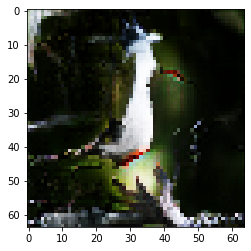

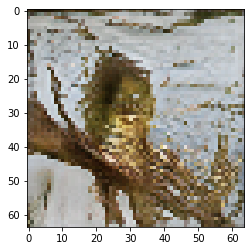

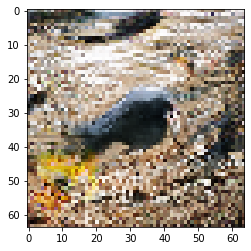

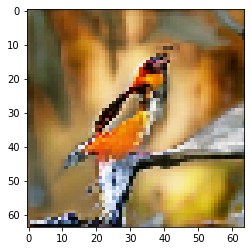

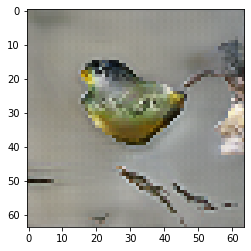

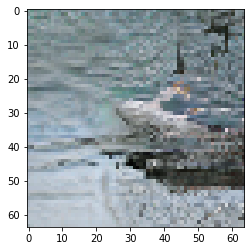

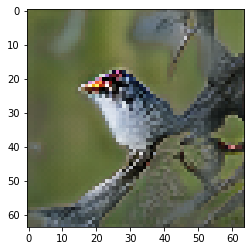

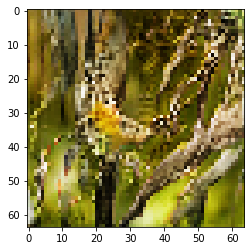

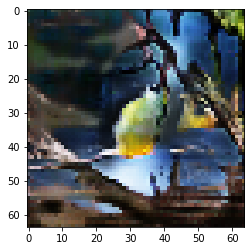

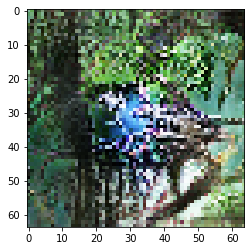

In [33]:
for i in range(10):
    noise = np.random.normal(0, 1, 100)

    generated_image = generator.predict(np.array([noise]))[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()

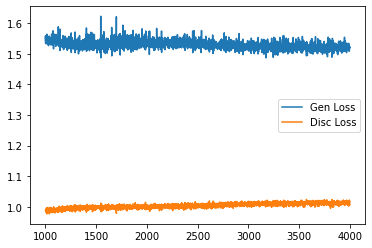

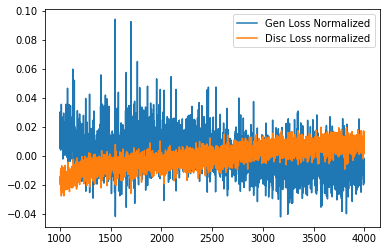

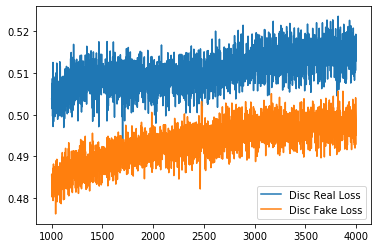

In [40]:
plt.plot([x for x in range(1000, 1000 + len(gen_loss_hist))], gen_loss_hist)
plt.plot([x for x in range(1000, 1000 + len(disc_loss_hist))], disc_loss_hist)

plt.legend(['Gen Loss','Disc Loss'])
plt.show()

plt.plot([x for x in range(1000, 1000 + len(gen_loss_hist))], gen_loss_hist - np.mean(gen_loss_hist))
plt.plot([x for x in range(1000, 1000 + len(disc_loss_hist))], disc_loss_hist - np.mean(disc_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Loss normalized'])
plt.show()

plt.plot([x for x in range(1000, 1000 + len(disc_loss_real_hist))], disc_loss_real_hist)
plt.plot([x for x in range(1000, 1000 + len(disc_loss_fake_hist))], disc_loss_fake_hist)
plt.legend(['Disc Real Loss','Disc Fake Loss'])
plt.show()